In [1]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions,title="Confusion Matrix"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


def read_data(file_path):

    """
    This function reads the accelerometer data from a file
    Args:
        file_path: URL pointing to the CSV file
    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels






In [3]:
import pickle
def read_h5():
    lst = []
    with open("X and Y Dataset/x_train.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/y_train.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/x_test.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/y_test.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    return lst
def read_properties():
    lst = None
    with open('X and Y Dataset/properties.pickle','rb+') as fd:
        lst = pickle.load(fd)
    return lst
x_train,y_train,x_test,y_test = read_h5()
TIME_PERIODS = 80
num_time_periods, num_sensors,num_classes,input_shape = read_properties()
LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]


--- Create neural network model ---

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 71, 10)            310       
_________________________________________________________________
global_average_pooling1d_1 ( (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 66        
Total params: 376
Trainable params: 376
Non-trainable params: 0
_________________________________________________________________
None

--- Fit the model ---

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 0s 28us/step - loss: 1.6125 - accuracy: 0.4327 - val_loss: 1.3291 - val_accuracy

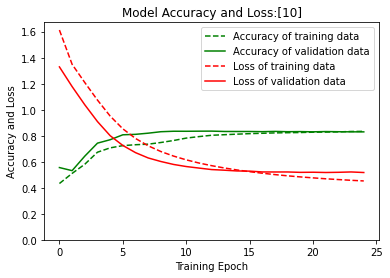


--- Check against test data ---

6584/6584 [==============================] - 0s 24us/step

Accuracy on test data: 0.81

Loss on test data: 0.54

--- Confusion matrix for test data ---



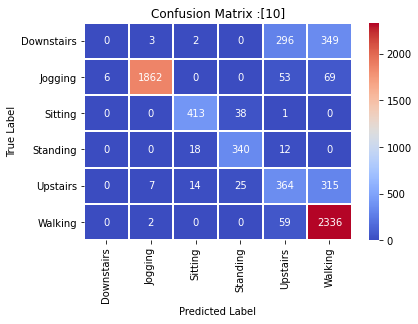


--- Classification report for test data [10]---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.99      0.94      0.96      1990
           2       0.92      0.91      0.92       452
           3       0.84      0.92      0.88       370
           4       0.46      0.50      0.48       725
           5       0.76      0.97      0.85      2397

    accuracy                           0.81      6584
   macro avg       0.66      0.71      0.68      6584
weighted avg       0.74      0.81      0.77      6584



0.8072600364685059

In [4]:
print("\n--- Create neural network model ---\n")
def call_model(cnnDim=None):
    if cnnDim == None:
        cnnDim = [
            10
        ]
    # 1D CNN neural network
    model_m = Sequential()
    model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
    for index in range(len(cnnDim)):
        if index ==0:
            model_m.add(Conv1D(10, cnnDim[index], activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
        else:
            model_m.add(Conv1D(100, cnnDim[index], activation='relu'))
        
#     model_m.add(MaxPooling1D(3))
#     model_m.add(Conv1D(filters_val, kernal_val, activation='relu'))
    model_m.add(GlobalAveragePooling1D())
    model_m.add(Dense(num_classes, activation='softmax'))
    print(model_m.summary())

    print("\n--- Fit the model ---\n")

    # The EarlyStopping callback monitors training accuracy:
    # if it fails to improve for two consecutive epochs,
    # training stops early
    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
    ]

    model_m.compile(loss='categorical_crossentropy',
                    optimizer='adam', metrics=['accuracy'])

    BATCH_SIZE = 200
    EPOCHS = 25

    # Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
    history = model_m.fit(x_train,
                          y_train,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          callbacks=callbacks_list,
                          validation_split=0.2,
                          verbose=1)

    print("\n--- Learning curve of model training ---\n")

    # summarize history for accuracy and loss
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
    plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
    plt.plot(history.history['loss'], "r--", label="Loss of training data")
    plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
    plt.title('Model Accuracy and Loss:'+str(cnnDim))
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()
    print("\n--- Check against test data ---\n")

    score = model_m.evaluate(x_test, y_test, verbose=1)

    print("\nAccuracy on test data: %0.2f" % score[1])
    print("\nLoss on test data: %0.2f" % score[0])

    print("\n--- Confusion matrix for test data ---\n")

    y_pred_test = model_m.predict(x_test)
    # Take the class with the highest probability from the test predictions
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(y_test, axis=1)

    show_confusion_matrix(max_y_test, max_y_pred_test,title="Confusion Matrix :"+str(cnnDim))
    print("\n--- Classification report for test data "+str(cnnDim)+"---\n")

    print(classification_report(max_y_test, max_y_pred_test))
    return score[1]
call_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 79, 10)            70        
_________________________________________________________________
global_average_pooling1d_2 ( (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 66        
Total params: 136
Trainable params: 136
Non-trainable params: 0
_________________________________________________________________
None

--- Fit the model ---

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 0s 23us/step - loss: 1.6582 - accuracy: 0.3559 - val_loss: 1.4896 - val_accuracy: 0.5659
Epoch 2/25
16694/16694 [=====

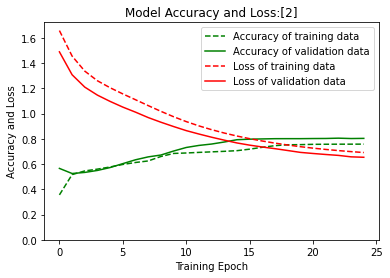


--- Check against test data ---

6584/6584 [==============================] - 0s 18us/step

Accuracy on test data: 0.68

Loss on test data: 0.77

--- Confusion matrix for test data ---



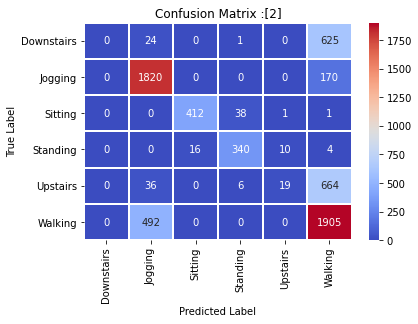


--- Classification report for test data [2]---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.77      0.91      0.83      1990
           2       0.96      0.91      0.94       452
           3       0.88      0.92      0.90       370
           4       0.63      0.03      0.05       725
           5       0.57      0.79      0.66      2397

    accuracy                           0.68      6584
   macro avg       0.64      0.59      0.56      6584
weighted avg       0.62      0.68      0.61      6584

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 76, 10)            160       
________________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 0s 27us/step - loss: 1.5205 - accuracy: 0.3227 - val_loss: 1.3322 - val_accuracy: 0.3857
Epoch 2/25
16694/16694 [==============================] - 0s 22us/step - loss: 1.2966 - accuracy: 0.5295 - val_loss: 1.1539 - val_accuracy: 0.5860
Epoch 3/25
16694/16694 [==============================] - 0s 23us/step - loss: 1.1659 - accuracy: 0.6133 - val_loss: 1.0489 - val_accuracy: 0.6246
Epoch 4/25
16694/16694 [==============================] - 0s 18us/step - loss: 1.0753 - accuracy: 0.6717 - val_loss: 0.9726 - val_accuracy: 0.6593
Epoch 5/25
16694/16694 [==============================] - 0s 24us/step - loss: 1.0035 - accuracy: 0.6913 - val_loss: 0.9161 - val_accuracy: 0.6811
Epoch 6/25
16694/16694 [==============================] - 0s 23us/step - loss: 0.9458 - accuracy: 0.6985 - val_loss: 0.8621 - val_accuracy: 0.7034
Epoch 7/25
16694/16694 [==============================] - 0s 21us/ste

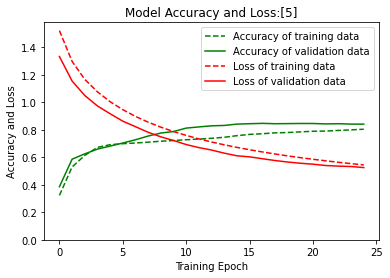


--- Check against test data ---

6584/6584 [==============================] - 0s 33us/step

Accuracy on test data: 0.78

Loss on test data: 0.59

--- Confusion matrix for test data ---



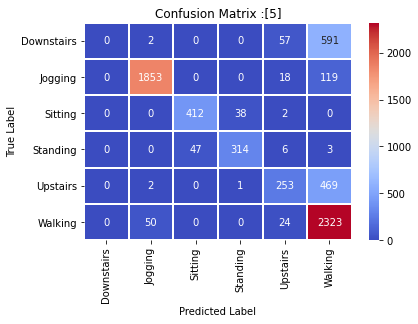


--- Classification report for test data [5]---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.97      0.93      0.95      1990
           2       0.90      0.91      0.90       452
           3       0.89      0.85      0.87       370
           4       0.70      0.35      0.47       725
           5       0.66      0.97      0.79      2397

    accuracy                           0.78      6584
   macro avg       0.69      0.67      0.66      6584
weighted avg       0.72      0.78      0.74      6584

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 73, 10)            250       
________________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 39us/step - loss: 1.4831 - accuracy: 0.4394 - val_loss: 1.2509 - val_accuracy: 0.5647
Epoch 2/25
16694/16694 [==============================] - 1s 36us/step - loss: 1.2351 - accuracy: 0.5657 - val_loss: 1.1028 - val_accuracy: 0.5822
Epoch 3/25
16694/16694 [==============================] - 1s 35us/step - loss: 1.1021 - accuracy: 0.6254 - val_loss: 0.9895 - val_accuracy: 0.6493
Epoch 4/25
16694/16694 [==============================] - 1s 32us/step - loss: 0.9921 - accuracy: 0.6991 - val_loss: 0.8902 - val_accuracy: 0.7523
Epoch 5/25
16694/16694 [==============================] - 0s 30us/step - loss: 0.9031 - accuracy: 0.7188 - val_loss: 0.8152 - val_accuracy: 0.7717
Epoch 6/25
16694/16694 [==============================] - 0s 23us/step - loss: 0.8336 - accuracy: 0.7258 - val_loss: 0.7560 - val_accuracy: 0.7772
Epoch 7/25
16694/16694 [==============================] - 0s 22us/ste

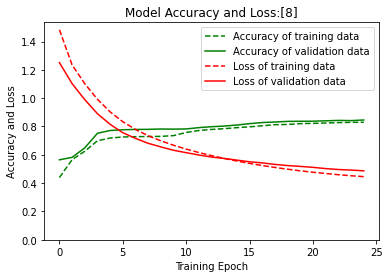


--- Check against test data ---

6584/6584 [==============================] - 0s 42us/step

Accuracy on test data: 0.81

Loss on test data: 0.53

--- Confusion matrix for test data ---



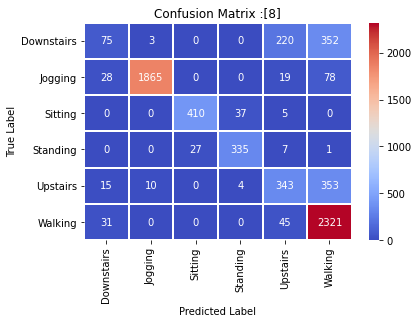


--- Classification report for test data [8]---

              precision    recall  f1-score   support

           0       0.50      0.12      0.19       650
           1       0.99      0.94      0.96      1990
           2       0.94      0.91      0.92       452
           3       0.89      0.91      0.90       370
           4       0.54      0.47      0.50       725
           5       0.75      0.97      0.84      2397

    accuracy                           0.81      6584
   macro avg       0.77      0.72      0.72      6584
weighted avg       0.80      0.81      0.79      6584

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 71, 10)            310       
________________________________________________________

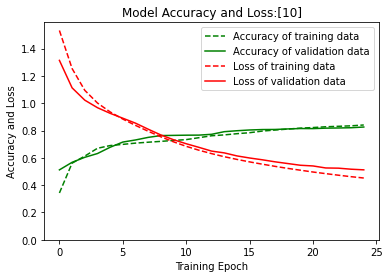


--- Check against test data ---

6584/6584 [==============================] - 0s 42us/step

Accuracy on test data: 0.82

Loss on test data: 0.53

--- Confusion matrix for test data ---



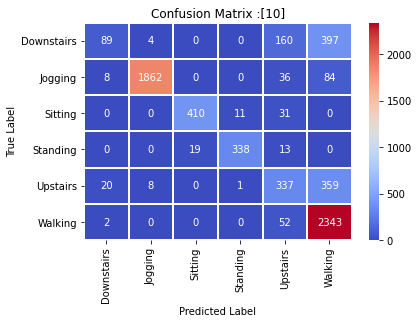


--- Classification report for test data [10]---

              precision    recall  f1-score   support

           0       0.75      0.14      0.23       650
           1       0.99      0.94      0.96      1990
           2       0.96      0.91      0.93       452
           3       0.97      0.91      0.94       370
           4       0.54      0.46      0.50       725
           5       0.74      0.98      0.84      2397

    accuracy                           0.82      6584
   macro avg       0.82      0.72      0.73      6584
weighted avg       0.82      0.82      0.79      6584

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 69, 10)            370       
_______________________________________________________

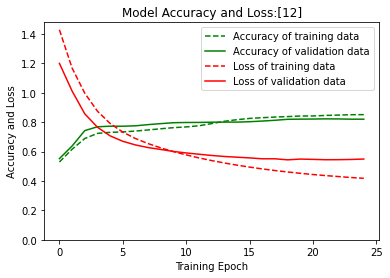


--- Check against test data ---

6584/6584 [==============================] - 0s 54us/step

Accuracy on test data: 0.82

Loss on test data: 0.56

--- Confusion matrix for test data ---



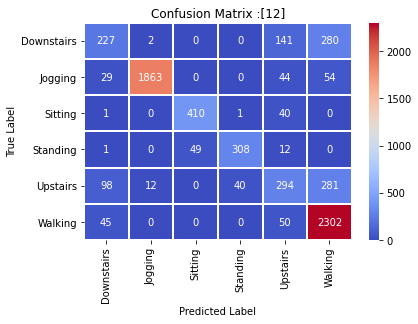


--- Classification report for test data [12]---

              precision    recall  f1-score   support

           0       0.57      0.35      0.43       650
           1       0.99      0.94      0.96      1990
           2       0.89      0.91      0.90       452
           3       0.88      0.83      0.86       370
           4       0.51      0.41      0.45       725
           5       0.79      0.96      0.87      2397

    accuracy                           0.82      6584
   macro avg       0.77      0.73      0.74      6584
weighted avg       0.81      0.82      0.81      6584

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 66, 10)            460       
_______________________________________________________

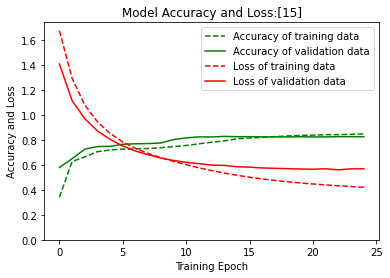


--- Check against test data ---

6584/6584 [==============================] - 0s 36us/step

Accuracy on test data: 0.83

Loss on test data: 0.56

--- Confusion matrix for test data ---



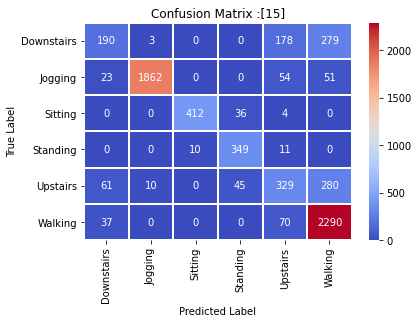


--- Classification report for test data [15]---

              precision    recall  f1-score   support

           0       0.61      0.29      0.40       650
           1       0.99      0.94      0.96      1990
           2       0.98      0.91      0.94       452
           3       0.81      0.94      0.87       370
           4       0.51      0.45      0.48       725
           5       0.79      0.96      0.86      2397

    accuracy                           0.83      6584
   macro avg       0.78      0.75      0.75      6584
weighted avg       0.82      0.83      0.81      6584

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 63, 10)            550       
_______________________________________________________

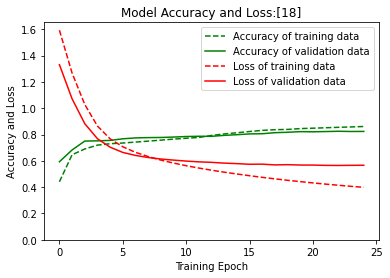


--- Check against test data ---

6584/6584 [==============================] - 0s 27us/step

Accuracy on test data: 0.83

Loss on test data: 0.55

--- Confusion matrix for test data ---



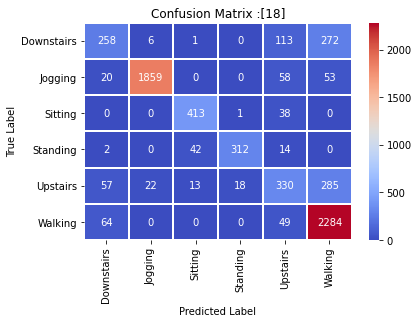


--- Classification report for test data [18]---

              precision    recall  f1-score   support

           0       0.64      0.40      0.49       650
           1       0.99      0.93      0.96      1990
           2       0.88      0.91      0.90       452
           3       0.94      0.84      0.89       370
           4       0.55      0.46      0.50       725
           5       0.79      0.95      0.86      2397

    accuracy                           0.83      6584
   macro avg       0.80      0.75      0.77      6584
weighted avg       0.82      0.83      0.82      6584

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 61, 10)            610       
_______________________________________________________

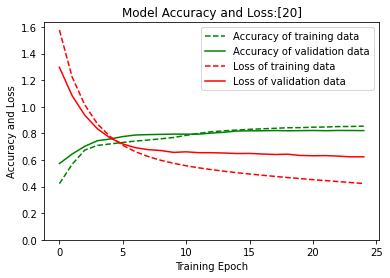


--- Check against test data ---

6584/6584 [==============================] - 0s 26us/step

Accuracy on test data: 0.82

Loss on test data: 0.60

--- Confusion matrix for test data ---



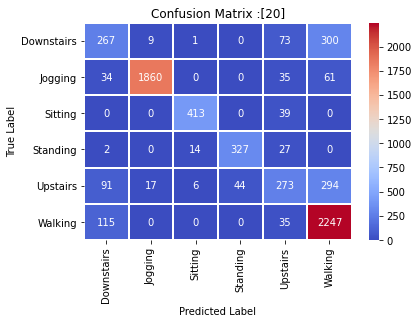


--- Classification report for test data [20]---

              precision    recall  f1-score   support

           0       0.52      0.41      0.46       650
           1       0.99      0.93      0.96      1990
           2       0.95      0.91      0.93       452
           3       0.88      0.88      0.88       370
           4       0.57      0.38      0.45       725
           5       0.77      0.94      0.85      2397

    accuracy                           0.82      6584
   macro avg       0.78      0.74      0.76      6584
weighted avg       0.81      0.82      0.81      6584

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 79, 10)            70        
______________________________________________________

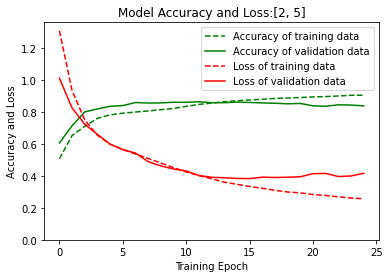


--- Check against test data ---

6584/6584 [==============================] - 1s 77us/step

Accuracy on test data: 0.85

Loss on test data: 0.44

--- Confusion matrix for test data ---



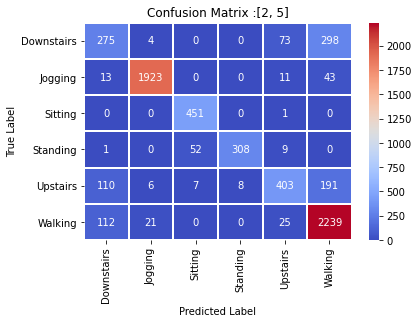


--- Classification report for test data [2, 5]---

              precision    recall  f1-score   support

           0       0.54      0.42      0.47       650
           1       0.98      0.97      0.98      1990
           2       0.88      1.00      0.94       452
           3       0.97      0.83      0.90       370
           4       0.77      0.56      0.65       725
           5       0.81      0.93      0.87      2397

    accuracy                           0.85      6584
   macro avg       0.83      0.78      0.80      6584
weighted avg       0.85      0.85      0.84      6584

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 79, 10)            70        
____________________________________________________

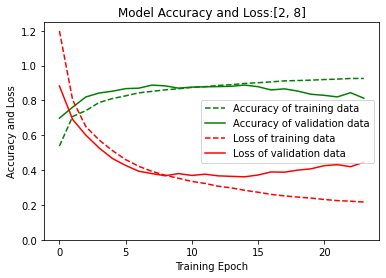


--- Check against test data ---

6584/6584 [==============================] - 1s 89us/step

Accuracy on test data: 0.87

Loss on test data: 0.44

--- Confusion matrix for test data ---



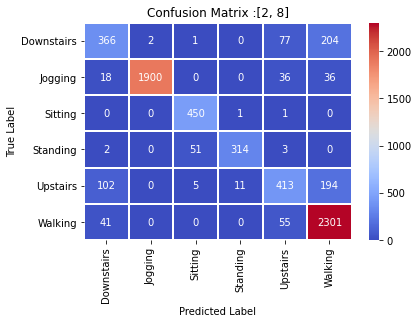


--- Classification report for test data [2, 8]---

              precision    recall  f1-score   support

           0       0.69      0.56      0.62       650
           1       1.00      0.95      0.98      1990
           2       0.89      1.00      0.94       452
           3       0.96      0.85      0.90       370
           4       0.71      0.57      0.63       725
           5       0.84      0.96      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.85      0.82      0.83      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 79, 10)            70        
____________________________________________________

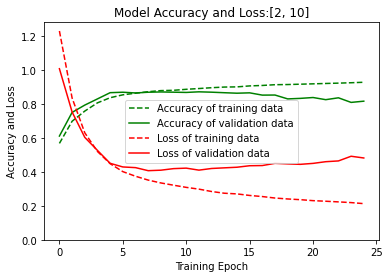


--- Check against test data ---

6584/6584 [==============================] - 0s 66us/step

Accuracy on test data: 0.88

Loss on test data: 0.41

--- Confusion matrix for test data ---



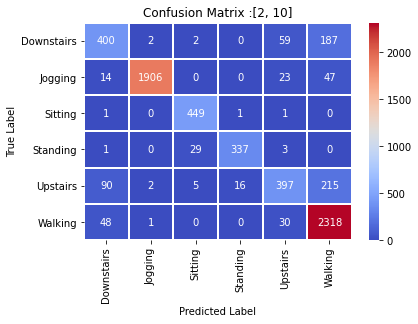


--- Classification report for test data [2, 10]---

              precision    recall  f1-score   support

           0       0.72      0.62      0.66       650
           1       1.00      0.96      0.98      1990
           2       0.93      0.99      0.96       452
           3       0.95      0.91      0.93       370
           4       0.77      0.55      0.64       725
           5       0.84      0.97      0.90      2397

    accuracy                           0.88      6584
   macro avg       0.87      0.83      0.85      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 79, 10)            70        
___________________________________________________

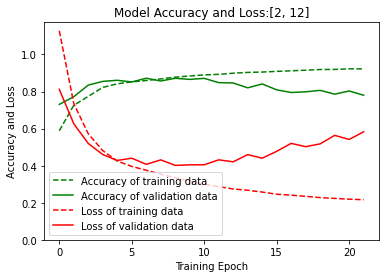


--- Check against test data ---

6584/6584 [==============================] - 0s 72us/step

Accuracy on test data: 0.88

Loss on test data: 0.39

--- Confusion matrix for test data ---



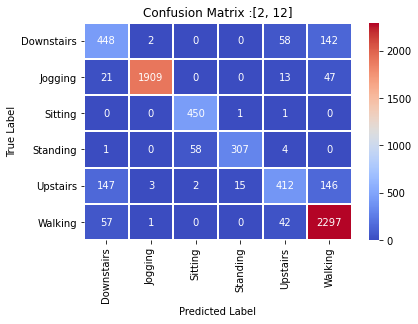


--- Classification report for test data [2, 12]---

              precision    recall  f1-score   support

           0       0.66      0.69      0.68       650
           1       1.00      0.96      0.98      1990
           2       0.88      1.00      0.94       452
           3       0.95      0.83      0.89       370
           4       0.78      0.57      0.66       725
           5       0.87      0.96      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.83      0.84      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_14 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 79, 10)            70        
___________________________________________________

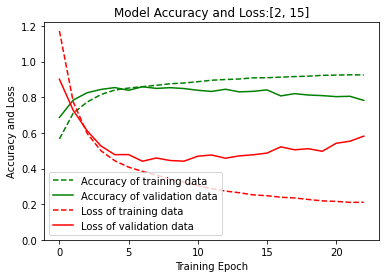


--- Check against test data ---

6584/6584 [==============================] - 1s 89us/step

Accuracy on test data: 0.88

Loss on test data: 0.38

--- Confusion matrix for test data ---



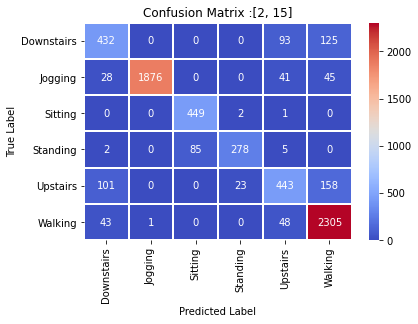


--- Classification report for test data [2, 15]---

              precision    recall  f1-score   support

           0       0.71      0.66      0.69       650
           1       1.00      0.94      0.97      1990
           2       0.84      0.99      0.91       452
           3       0.92      0.75      0.83       370
           4       0.70      0.61      0.65       725
           5       0.88      0.96      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.84      0.82      0.83      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_15 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 79, 10)            70        
___________________________________________________

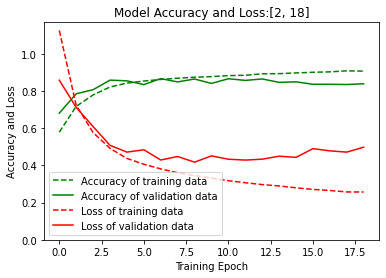


--- Check against test data ---

6584/6584 [==============================] - 1s 99us/step

Accuracy on test data: 0.84

Loss on test data: 0.54

--- Confusion matrix for test data ---



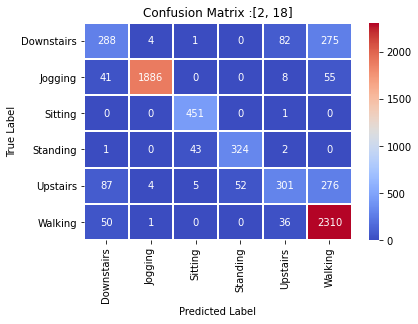


--- Classification report for test data [2, 18]---

              precision    recall  f1-score   support

           0       0.62      0.44      0.52       650
           1       1.00      0.95      0.97      1990
           2       0.90      1.00      0.95       452
           3       0.86      0.88      0.87       370
           4       0.70      0.42      0.52       725
           5       0.79      0.96      0.87      2397

    accuracy                           0.84      6584
   macro avg       0.81      0.77      0.78      6584
weighted avg       0.84      0.84      0.83      6584

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 79, 10)            70        
___________________________________________________

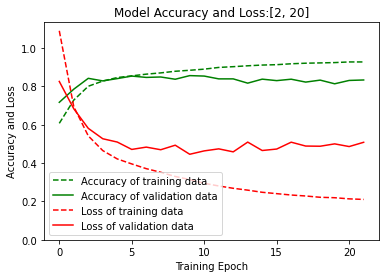


--- Check against test data ---

6584/6584 [==============================] - 1s 122us/step

Accuracy on test data: 0.87

Loss on test data: 0.42

--- Confusion matrix for test data ---



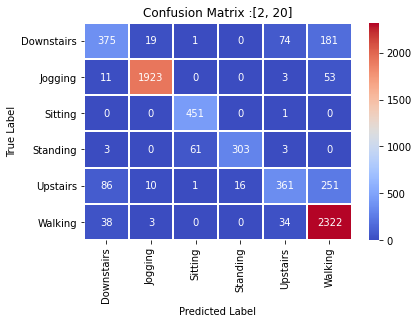


--- Classification report for test data [2, 20]---

              precision    recall  f1-score   support

           0       0.73      0.58      0.64       650
           1       0.98      0.97      0.97      1990
           2       0.88      1.00      0.93       452
           3       0.95      0.82      0.88       370
           4       0.76      0.50      0.60       725
           5       0.83      0.97      0.89      2397

    accuracy                           0.87      6584
   macro avg       0.85      0.80      0.82      6584
weighted avg       0.87      0.87      0.86      6584

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_17 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 76, 10)            160       
___________________________________________________

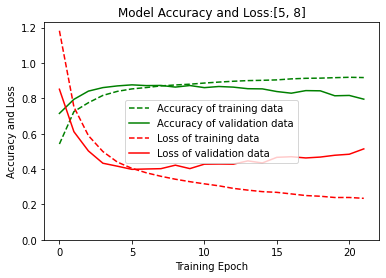


--- Check against test data ---

6584/6584 [==============================] - 1s 80us/step

Accuracy on test data: 0.88

Loss on test data: 0.44

--- Confusion matrix for test data ---



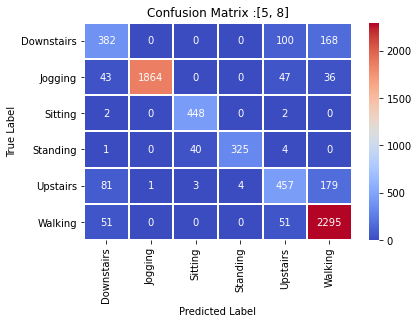


--- Classification report for test data [5, 8]---

              precision    recall  f1-score   support

           0       0.68      0.59      0.63       650
           1       1.00      0.94      0.97      1990
           2       0.91      0.99      0.95       452
           3       0.99      0.88      0.93       370
           4       0.69      0.63      0.66       725
           5       0.86      0.96      0.90      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.83      0.84      6584
weighted avg       0.88      0.88      0.87      6584

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_18 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 76, 10)            160       
____________________________________________________

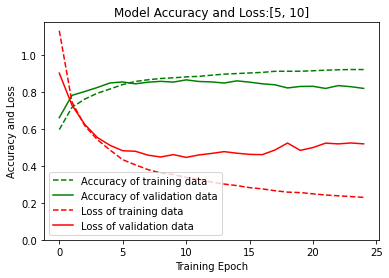


--- Check against test data ---

6584/6584 [==============================] - 1s 91us/step

Accuracy on test data: 0.87

Loss on test data: 0.43

--- Confusion matrix for test data ---



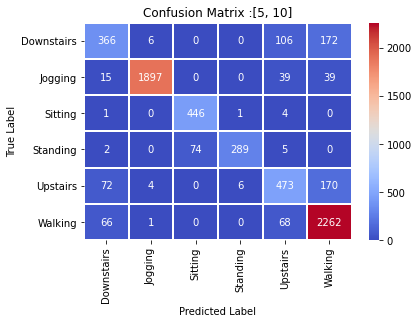


--- Classification report for test data [5, 10]---

              precision    recall  f1-score   support

           0       0.70      0.56      0.62       650
           1       0.99      0.95      0.97      1990
           2       0.86      0.99      0.92       452
           3       0.98      0.78      0.87       370
           4       0.68      0.65      0.67       725
           5       0.86      0.94      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_19 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 76, 10)            160       
___________________________________________________

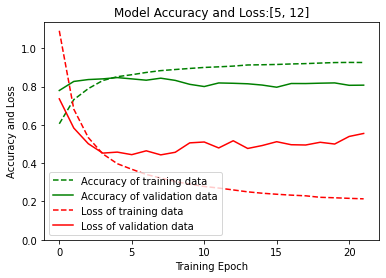


--- Check against test data ---

6584/6584 [==============================] - 1s 88us/step

Accuracy on test data: 0.88

Loss on test data: 0.43

--- Confusion matrix for test data ---



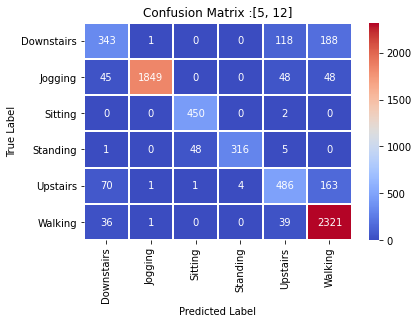


--- Classification report for test data [5, 12]---

              precision    recall  f1-score   support

           0       0.69      0.53      0.60       650
           1       1.00      0.93      0.96      1990
           2       0.90      1.00      0.95       452
           3       0.99      0.85      0.92       370
           4       0.70      0.67      0.68       725
           5       0.85      0.97      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.82      0.84      6584
weighted avg       0.87      0.88      0.87      6584

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_20 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 76, 10)            160       
___________________________________________________

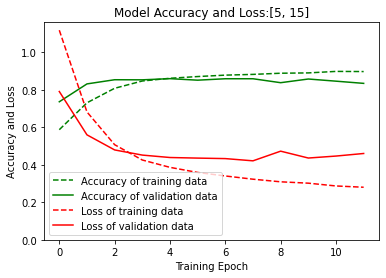


--- Check against test data ---

6584/6584 [==============================] - 1s 81us/step

Accuracy on test data: 0.86

Loss on test data: 0.45

--- Confusion matrix for test data ---



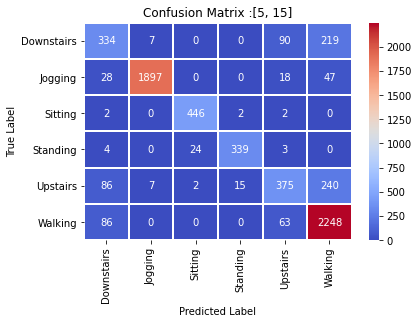


--- Classification report for test data [5, 15]---

              precision    recall  f1-score   support

           0       0.62      0.51      0.56       650
           1       0.99      0.95      0.97      1990
           2       0.94      0.99      0.97       452
           3       0.95      0.92      0.93       370
           4       0.68      0.52      0.59       725
           5       0.82      0.94      0.87      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.80      0.82      6584
weighted avg       0.85      0.86      0.85      6584

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_21 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 76, 10)            160       
___________________________________________________

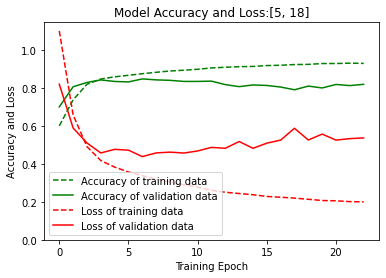


--- Check against test data ---

6584/6584 [==============================] - ETA:  - 1s 78us/step

Accuracy on test data: 0.88

Loss on test data: 0.44

--- Confusion matrix for test data ---



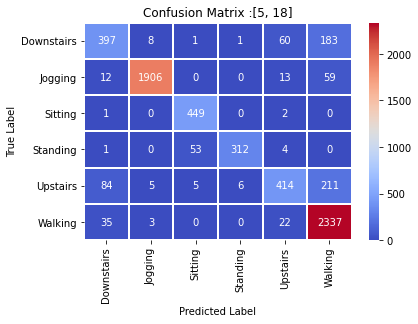


--- Classification report for test data [5, 18]---

              precision    recall  f1-score   support

           0       0.75      0.61      0.67       650
           1       0.99      0.96      0.97      1990
           2       0.88      0.99      0.94       452
           3       0.98      0.84      0.91       370
           4       0.80      0.57      0.67       725
           5       0.84      0.97      0.90      2397

    accuracy                           0.88      6584
   macro avg       0.87      0.83      0.84      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_22 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 76, 10)            160       
___________________________________________________

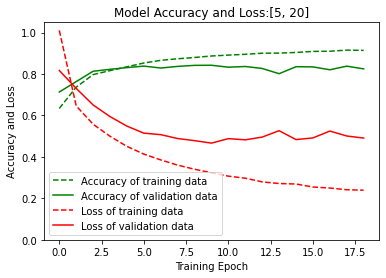


--- Check against test data ---

6584/6584 [==============================] - 1s 83us/step

Accuracy on test data: 0.86

Loss on test data: 0.43

--- Confusion matrix for test data ---



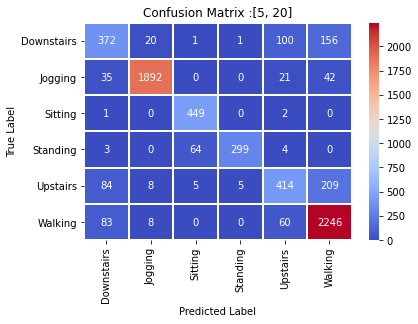


--- Classification report for test data [5, 20]---

              precision    recall  f1-score   support

           0       0.64      0.57      0.61       650
           1       0.98      0.95      0.97      1990
           2       0.87      0.99      0.92       452
           3       0.98      0.81      0.89       370
           4       0.69      0.57      0.62       725
           5       0.85      0.94      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.81      0.82      6584
weighted avg       0.86      0.86      0.86      6584

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_23 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 73, 10)            250       
___________________________________________________

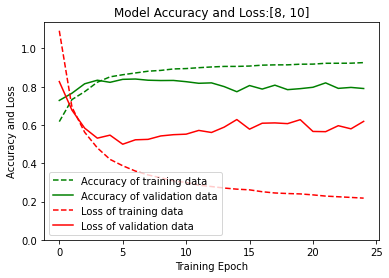


--- Check against test data ---

6584/6584 [==============================] - 1s 87us/step

Accuracy on test data: 0.88

Loss on test data: 0.44

--- Confusion matrix for test data ---



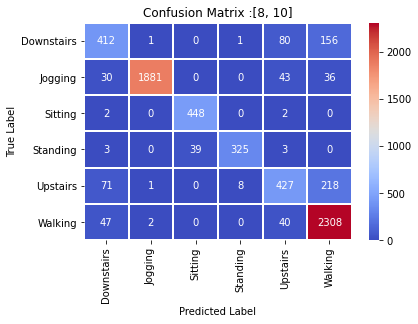


--- Classification report for test data [8, 10]---

              precision    recall  f1-score   support

           0       0.73      0.63      0.68       650
           1       1.00      0.95      0.97      1990
           2       0.92      0.99      0.95       452
           3       0.97      0.88      0.92       370
           4       0.72      0.59      0.65       725
           5       0.85      0.96      0.90      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.83      0.85      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_24 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 73, 10)            250       
___________________________________________________

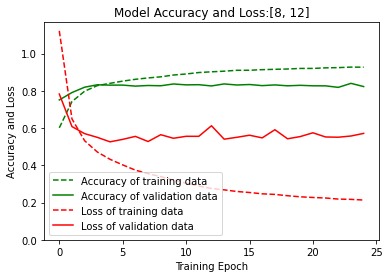


--- Check against test data ---

6584/6584 [==============================] - 1s 79us/step

Accuracy on test data: 0.89

Loss on test data: 0.43

--- Confusion matrix for test data ---



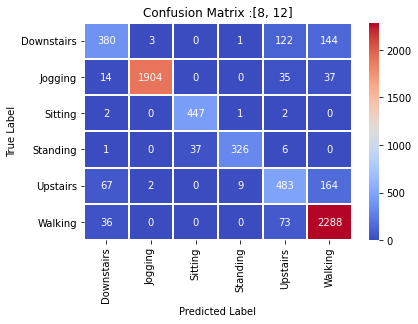


--- Classification report for test data [8, 12]---

              precision    recall  f1-score   support

           0       0.76      0.58      0.66       650
           1       1.00      0.96      0.98      1990
           2       0.92      0.99      0.96       452
           3       0.97      0.88      0.92       370
           4       0.67      0.67      0.67       725
           5       0.87      0.95      0.91      2397

    accuracy                           0.89      6584
   macro avg       0.86      0.84      0.85      6584
weighted avg       0.88      0.89      0.88      6584

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_25 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 73, 10)            250       
___________________________________________________

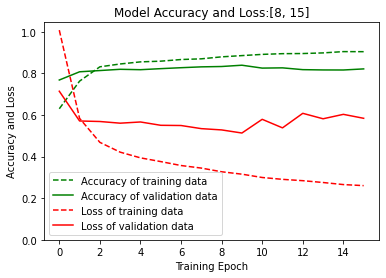


--- Check against test data ---

6584/6584 [==============================] - 1s 85us/step

Accuracy on test data: 0.86

Loss on test data: 0.45

--- Confusion matrix for test data ---



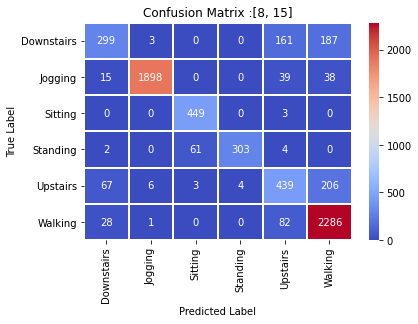


--- Classification report for test data [8, 15]---

              precision    recall  f1-score   support

           0       0.73      0.46      0.56       650
           1       0.99      0.95      0.97      1990
           2       0.88      0.99      0.93       452
           3       0.99      0.82      0.90       370
           4       0.60      0.61      0.60       725
           5       0.84      0.95      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.84      0.80      0.81      6584
weighted avg       0.86      0.86      0.86      6584

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_26 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 73, 10)            250       
___________________________________________________

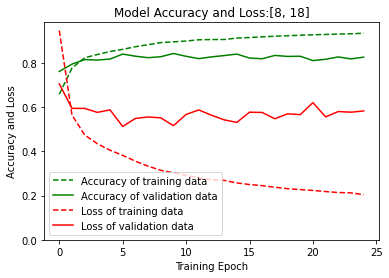


--- Check against test data ---

6584/6584 [==============================] - 1s 81us/step

Accuracy on test data: 0.87

Loss on test data: 0.46

--- Confusion matrix for test data ---



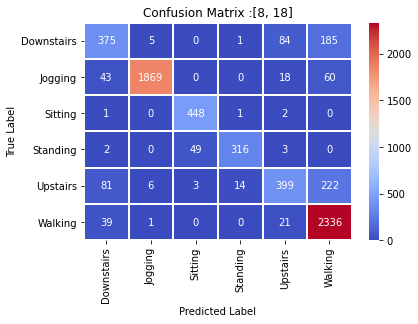


--- Classification report for test data [8, 18]---

              precision    recall  f1-score   support

           0       0.69      0.58      0.63       650
           1       0.99      0.94      0.97      1990
           2       0.90      0.99      0.94       452
           3       0.95      0.85      0.90       370
           4       0.76      0.55      0.64       725
           5       0.83      0.97      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.85      0.81      0.83      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_27 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 73, 10)            250       
___________________________________________________

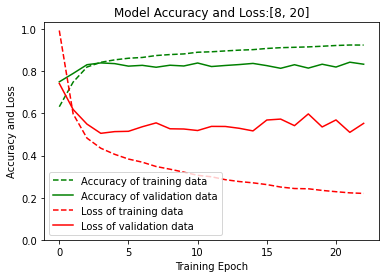


--- Check against test data ---

6584/6584 [==============================] - 1s 109us/step

Accuracy on test data: 0.86

Loss on test data: 0.46

--- Confusion matrix for test data ---



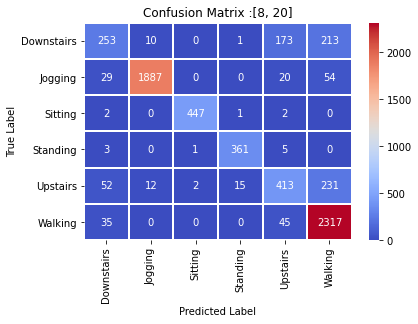


--- Classification report for test data [8, 20]---

              precision    recall  f1-score   support

           0       0.68      0.39      0.49       650
           1       0.99      0.95      0.97      1990
           2       0.99      0.99      0.99       452
           3       0.96      0.98      0.97       370
           4       0.63      0.57      0.60       725
           5       0.82      0.97      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.86      0.86      0.85      6584

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_28 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 71, 10)            310       
___________________________________________________

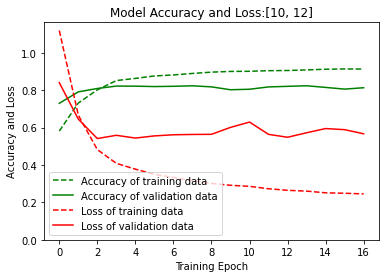


--- Check against test data ---

6584/6584 [==============================] - 1s 103us/step

Accuracy on test data: 0.87

Loss on test data: 0.47

--- Confusion matrix for test data ---



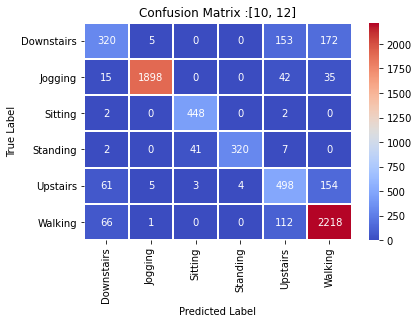


--- Classification report for test data [10, 12]---

              precision    recall  f1-score   support

           0       0.69      0.49      0.57       650
           1       0.99      0.95      0.97      1990
           2       0.91      0.99      0.95       452
           3       0.99      0.86      0.92       370
           4       0.61      0.69      0.65       725
           5       0.86      0.93      0.89      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.82      0.83      6584
weighted avg       0.87      0.87      0.86      6584

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_29 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 71, 10)            310       
__________________________________________________

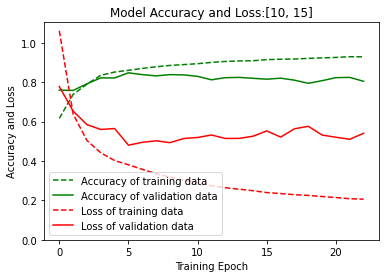


--- Check against test data ---

6584/6584 [==============================] - 1s 106us/step

Accuracy on test data: 0.88

Loss on test data: 0.42

--- Confusion matrix for test data ---



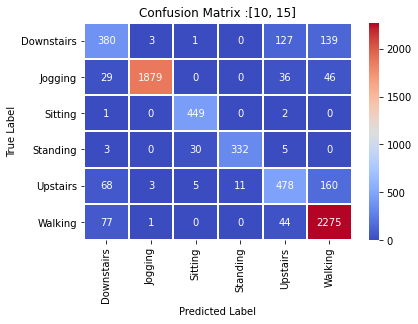


--- Classification report for test data [10, 15]---

              precision    recall  f1-score   support

           0       0.68      0.58      0.63       650
           1       1.00      0.94      0.97      1990
           2       0.93      0.99      0.96       452
           3       0.97      0.90      0.93       370
           4       0.69      0.66      0.67       725
           5       0.87      0.95      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.84      0.84      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_30 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 71, 10)            310       
__________________________________________________

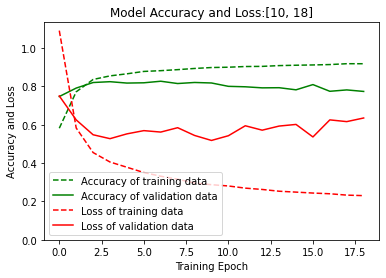


--- Check against test data ---

6584/6584 [==============================] - 1s 98us/step

Accuracy on test data: 0.87

Loss on test data: 0.44

--- Confusion matrix for test data ---



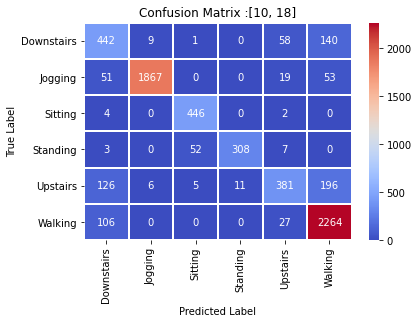


--- Classification report for test data [10, 18]---

              precision    recall  f1-score   support

           0       0.60      0.68      0.64       650
           1       0.99      0.94      0.96      1990
           2       0.88      0.99      0.93       452
           3       0.97      0.83      0.89       370
           4       0.77      0.53      0.63       725
           5       0.85      0.94      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.85      0.82      0.83      6584
weighted avg       0.87      0.87      0.86      6584

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_31 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 71, 10)            310       
__________________________________________________

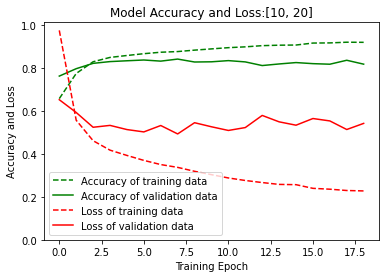


--- Check against test data ---

6584/6584 [==============================] - 1s 118us/step

Accuracy on test data: 0.88

Loss on test data: 0.41

--- Confusion matrix for test data ---



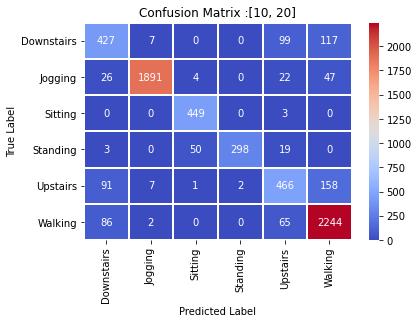


--- Classification report for test data [10, 20]---

              precision    recall  f1-score   support

           0       0.67      0.66      0.67       650
           1       0.99      0.95      0.97      1990
           2       0.89      0.99      0.94       452
           3       0.99      0.81      0.89       370
           4       0.69      0.64      0.67       725
           5       0.87      0.94      0.90      2397

    accuracy                           0.88      6584
   macro avg       0.85      0.83      0.84      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_32 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 69, 10)            370       
__________________________________________________

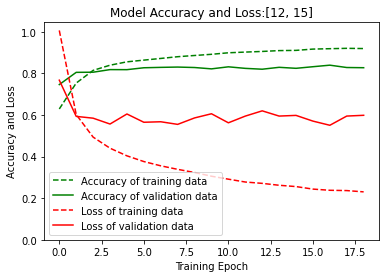


--- Check against test data ---

6584/6584 [==============================] - 1s 132us/step

Accuracy on test data: 0.88

Loss on test data: 0.43

--- Confusion matrix for test data ---



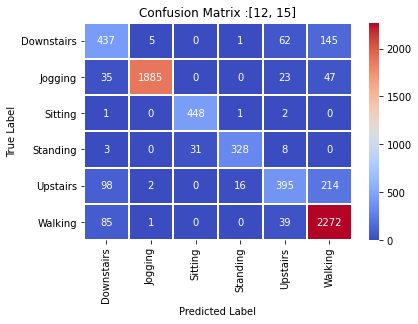


--- Classification report for test data [12, 15]---

              precision    recall  f1-score   support

           0       0.66      0.67      0.67       650
           1       1.00      0.95      0.97      1990
           2       0.94      0.99      0.96       452
           3       0.95      0.89      0.92       370
           4       0.75      0.54      0.63       725
           5       0.85      0.95      0.90      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.83      0.84      6584
weighted avg       0.88      0.88      0.87      6584

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_33 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 69, 10)            370       
__________________________________________________

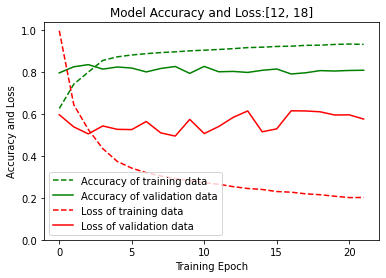


--- Check against test data ---

6584/6584 [==============================] - 1s 76us/step

Accuracy on test data: 0.88

Loss on test data: 0.41

--- Confusion matrix for test data ---



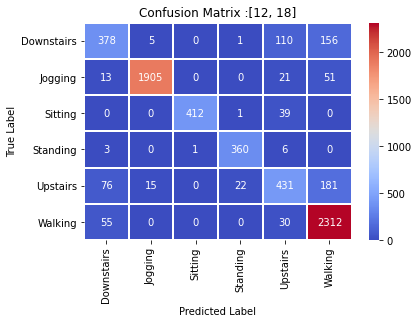


--- Classification report for test data [12, 18]---

              precision    recall  f1-score   support

           0       0.72      0.58      0.64       650
           1       0.99      0.96      0.97      1990
           2       1.00      0.91      0.95       452
           3       0.94      0.97      0.95       370
           4       0.68      0.59      0.63       725
           5       0.86      0.96      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.83      0.84      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_34 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 69, 10)            370       
__________________________________________________

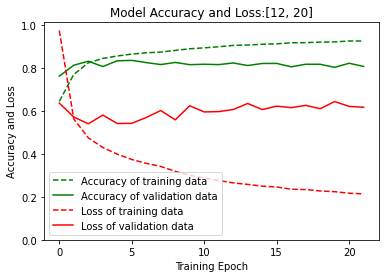


--- Check against test data ---

6584/6584 [==============================] - 1s 115us/step

Accuracy on test data: 0.87

Loss on test data: 0.40

--- Confusion matrix for test data ---



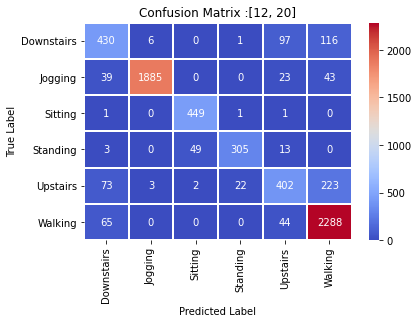


--- Classification report for test data [12, 20]---

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       650
           1       1.00      0.95      0.97      1990
           2       0.90      0.99      0.94       452
           3       0.93      0.82      0.87       370
           4       0.69      0.55      0.62       725
           5       0.86      0.95      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.85      0.82      0.83      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_35 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 66, 10)            460       
__________________________________________________

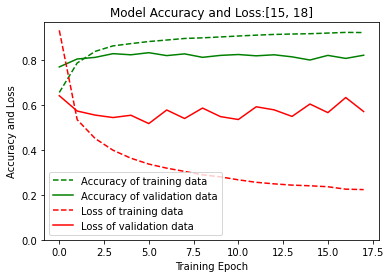


--- Check against test data ---

6584/6584 [==============================] - 1s 95us/step

Accuracy on test data: 0.87

Loss on test data: 0.45

--- Confusion matrix for test data ---



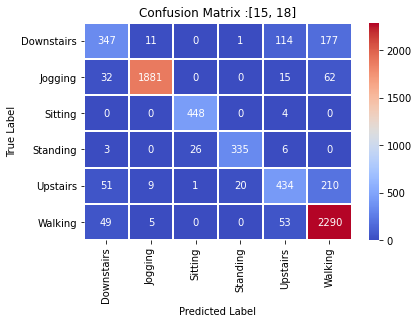


--- Classification report for test data [15, 18]---

              precision    recall  f1-score   support

           0       0.72      0.53      0.61       650
           1       0.99      0.95      0.97      1990
           2       0.94      0.99      0.97       452
           3       0.94      0.91      0.92       370
           4       0.69      0.60      0.64       725
           5       0.84      0.96      0.89      2397

    accuracy                           0.87      6584
   macro avg       0.85      0.82      0.83      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_36 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 66, 10)            460       
__________________________________________________

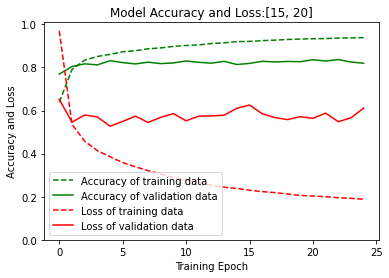


--- Check against test data ---

6584/6584 [==============================] - 1s 109us/step

Accuracy on test data: 0.87

Loss on test data: 0.44

--- Confusion matrix for test data ---



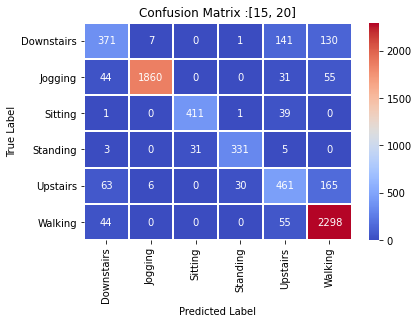


--- Classification report for test data [15, 20]---

              precision    recall  f1-score   support

           0       0.71      0.57      0.63       650
           1       0.99      0.93      0.96      1990
           2       0.93      0.91      0.92       452
           3       0.91      0.89      0.90       370
           4       0.63      0.64      0.63       725
           5       0.87      0.96      0.91      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.82      0.83      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_37 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 63, 10)            550       
__________________________________________________

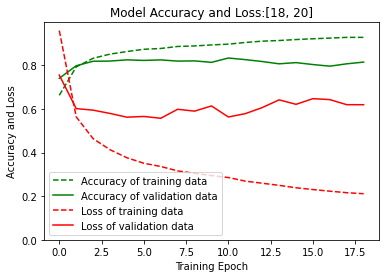


--- Check against test data ---

6584/6584 [==============================] - 1s 93us/step

Accuracy on test data: 0.86

Loss on test data: 0.48

--- Confusion matrix for test data ---



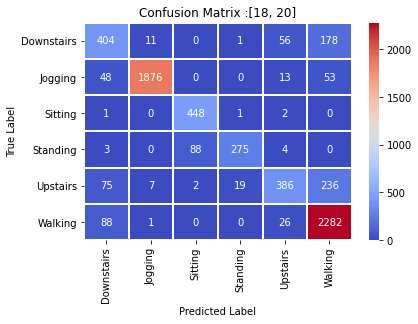


--- Classification report for test data [18, 20]---

              precision    recall  f1-score   support

           0       0.65      0.62      0.64       650
           1       0.99      0.94      0.97      1990
           2       0.83      0.99      0.91       452
           3       0.93      0.74      0.83       370
           4       0.79      0.53      0.64       725
           5       0.83      0.95      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.84      0.80      0.81      6584
weighted avg       0.86      0.86      0.86      6584

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_38 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 79, 10)            70        
__________________________________________________

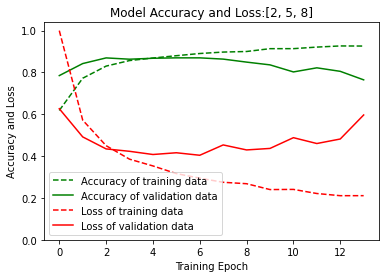


--- Check against test data ---

6584/6584 [==============================] - 2s 241us/step

Accuracy on test data: 0.87

Loss on test data: 0.41

--- Confusion matrix for test data ---



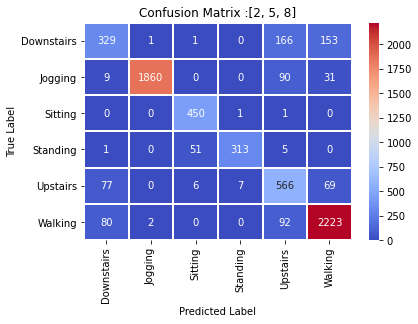


--- Classification report for test data [2, 5, 8]---

              precision    recall  f1-score   support

           0       0.66      0.51      0.57       650
           1       1.00      0.93      0.97      1990
           2       0.89      1.00      0.94       452
           3       0.98      0.85      0.91       370
           4       0.62      0.78      0.69       725
           5       0.90      0.93      0.91      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.83      0.83      6584
weighted avg       0.88      0.87      0.87      6584

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_39 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 79, 10)            70        
_________________________________________________

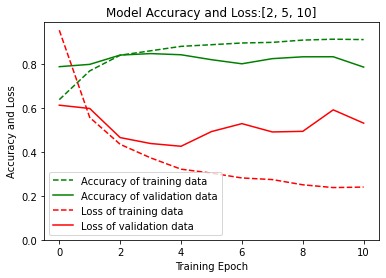


--- Check against test data ---

6584/6584 [==============================] - 2s 280us/step

Accuracy on test data: 0.88

Loss on test data: 0.39

--- Confusion matrix for test data ---



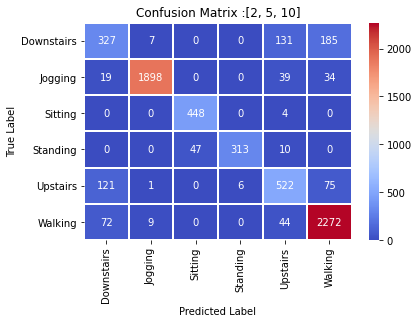


--- Classification report for test data [2, 5, 10]---

              precision    recall  f1-score   support

           0       0.61      0.50      0.55       650
           1       0.99      0.95      0.97      1990
           2       0.91      0.99      0.95       452
           3       0.98      0.85      0.91       370
           4       0.70      0.72      0.71       725
           5       0.89      0.95      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.84      0.83      0.83      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_40 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 79, 10)            70        
________________________________________________

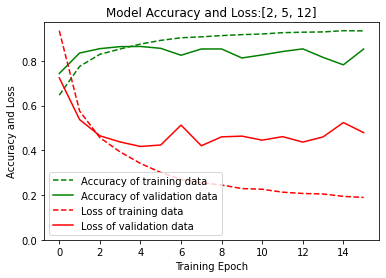


--- Check against test data ---

6584/6584 [==============================] - 2s 300us/step

Accuracy on test data: 0.88

Loss on test data: 0.39

--- Confusion matrix for test data ---



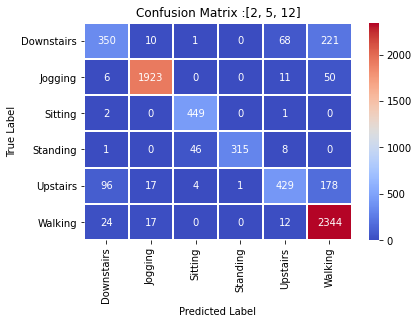


--- Classification report for test data [2, 5, 12]---

              precision    recall  f1-score   support

           0       0.73      0.54      0.62       650
           1       0.98      0.97      0.97      1990
           2       0.90      0.99      0.94       452
           3       1.00      0.85      0.92       370
           4       0.81      0.59      0.68       725
           5       0.84      0.98      0.90      2397

    accuracy                           0.88      6584
   macro avg       0.88      0.82      0.84      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_41 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 79, 10)            70        
________________________________________________

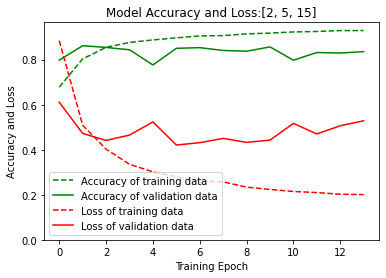


--- Check against test data ---

6584/6584 [==============================] - 2s 335us/step

Accuracy on test data: 0.87

Loss on test data: 0.42

--- Confusion matrix for test data ---



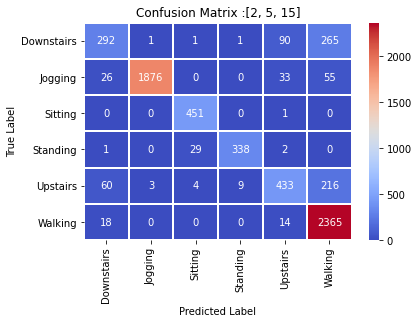


--- Classification report for test data [2, 5, 15]---

              precision    recall  f1-score   support

           0       0.74      0.45      0.56       650
           1       1.00      0.94      0.97      1990
           2       0.93      1.00      0.96       452
           3       0.97      0.91      0.94       370
           4       0.76      0.60      0.67       725
           5       0.82      0.99      0.89      2397

    accuracy                           0.87      6584
   macro avg       0.87      0.81      0.83      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_42 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_78 (Conv1D)           (None, 79, 10)            70        
________________________________________________

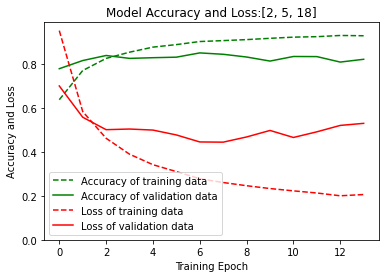


--- Check against test data ---

6584/6584 [==============================] - 2s 350us/step

Accuracy on test data: 0.86

Loss on test data: 0.47

--- Confusion matrix for test data ---



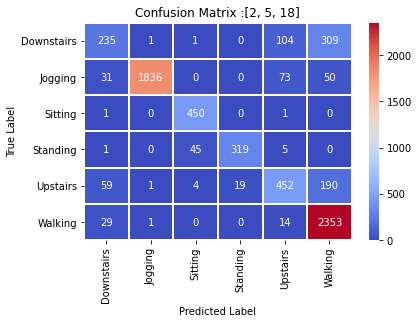


--- Classification report for test data [2, 5, 18]---

              precision    recall  f1-score   support

           0       0.66      0.36      0.47       650
           1       1.00      0.92      0.96      1990
           2       0.90      1.00      0.95       452
           3       0.94      0.86      0.90       370
           4       0.70      0.62      0.66       725
           5       0.81      0.98      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.79      0.80      6584
weighted avg       0.85      0.86      0.85      6584

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_43 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 79, 10)            70        
________________________________________________

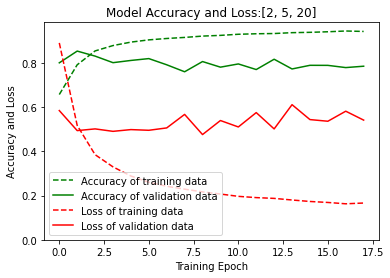


--- Check against test data ---

6584/6584 [==============================] - 3s 400us/step

Accuracy on test data: 0.90

Loss on test data: 0.36

--- Confusion matrix for test data ---



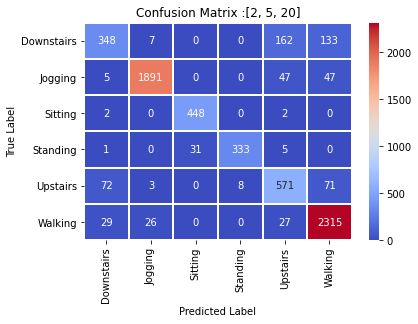


--- Classification report for test data [2, 5, 20]---

              precision    recall  f1-score   support

           0       0.76      0.54      0.63       650
           1       0.98      0.95      0.97      1990
           2       0.94      0.99      0.96       452
           3       0.98      0.90      0.94       370
           4       0.70      0.79      0.74       725
           5       0.90      0.97      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.86      0.86      6584
weighted avg       0.90      0.90      0.89      6584

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_44 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_84 (Conv1D)           (None, 79, 10)            70        
________________________________________________

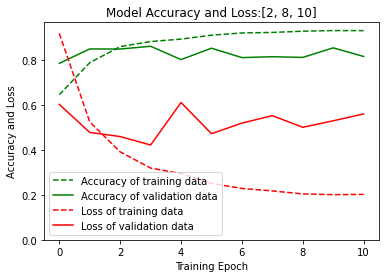


--- Check against test data ---

6584/6584 [==============================] - 2s 252us/step

Accuracy on test data: 0.89

Loss on test data: 0.41

--- Confusion matrix for test data ---



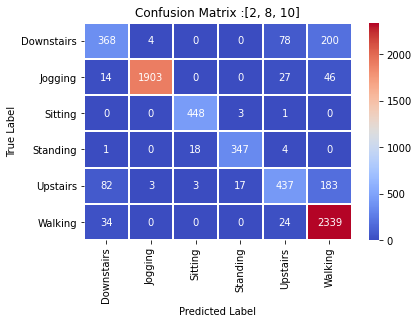


--- Classification report for test data [2, 8, 10]---

              precision    recall  f1-score   support

           0       0.74      0.57      0.64       650
           1       1.00      0.96      0.98      1990
           2       0.96      0.99      0.97       452
           3       0.95      0.94      0.94       370
           4       0.77      0.60      0.67       725
           5       0.85      0.98      0.91      2397

    accuracy                           0.89      6584
   macro avg       0.87      0.84      0.85      6584
weighted avg       0.88      0.89      0.88      6584

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_45 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_87 (Conv1D)           (None, 79, 10)            70        
________________________________________________

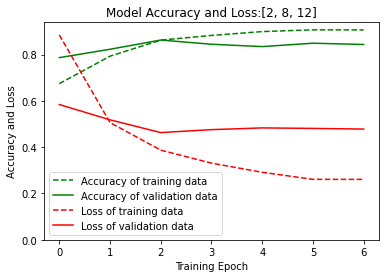


--- Check against test data ---

6584/6584 [==============================] - 2s 285us/step

Accuracy on test data: 0.87

Loss on test data: 0.39

--- Confusion matrix for test data ---



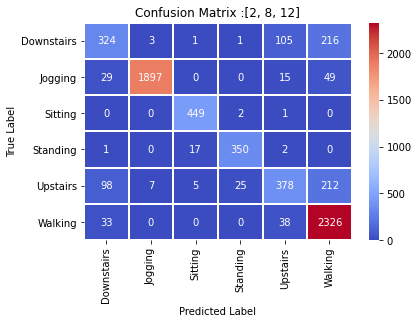


--- Classification report for test data [2, 8, 12]---

              precision    recall  f1-score   support

           0       0.67      0.50      0.57       650
           1       0.99      0.95      0.97      1990
           2       0.95      0.99      0.97       452
           3       0.93      0.95      0.94       370
           4       0.70      0.52      0.60       725
           5       0.83      0.97      0.89      2397

    accuracy                           0.87      6584
   macro avg       0.85      0.81      0.82      6584
weighted avg       0.86      0.87      0.86      6584

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_46 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_90 (Conv1D)           (None, 79, 10)            70        
________________________________________________

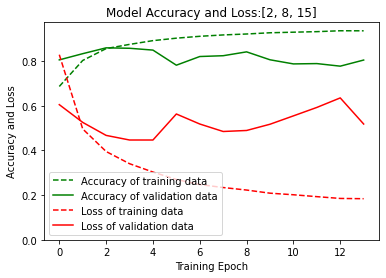


--- Check against test data ---

6584/6584 [==============================] - 2s 328us/step

Accuracy on test data: 0.90

Loss on test data: 0.35

--- Confusion matrix for test data ---



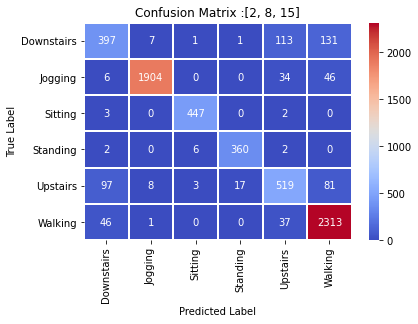


--- Classification report for test data [2, 8, 15]---

              precision    recall  f1-score   support

           0       0.72      0.61      0.66       650
           1       0.99      0.96      0.97      1990
           2       0.98      0.99      0.98       452
           3       0.95      0.97      0.96       370
           4       0.73      0.72      0.72       725
           5       0.90      0.96      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.87      0.87      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_47 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 79, 10)            70        
________________________________________________

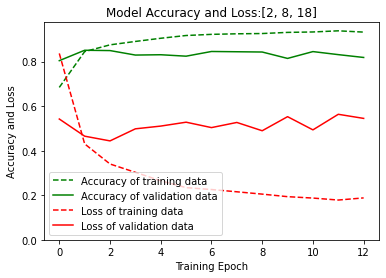


--- Check against test data ---

6584/6584 [==============================] - ETA:  - 2s 374us/step

Accuracy on test data: 0.90

Loss on test data: 0.33

--- Confusion matrix for test data ---



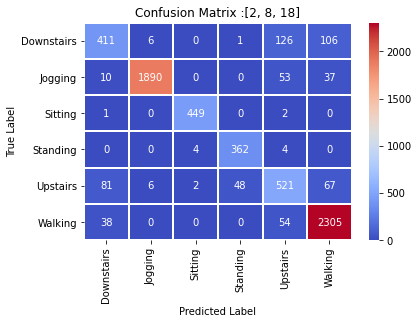


--- Classification report for test data [2, 8, 18]---

              precision    recall  f1-score   support

           0       0.76      0.63      0.69       650
           1       0.99      0.95      0.97      1990
           2       0.99      0.99      0.99       452
           3       0.88      0.98      0.93       370
           4       0.69      0.72      0.70       725
           5       0.92      0.96      0.94      2397

    accuracy                           0.90      6584
   macro avg       0.87      0.87      0.87      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_48 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_96 (Conv1D)           (None, 79, 10)            70        
________________________________________________

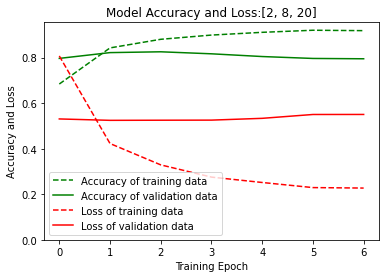


--- Check against test data ---

6584/6584 [==============================] - 2s 377us/step

Accuracy on test data: 0.90

Loss on test data: 0.35

--- Confusion matrix for test data ---



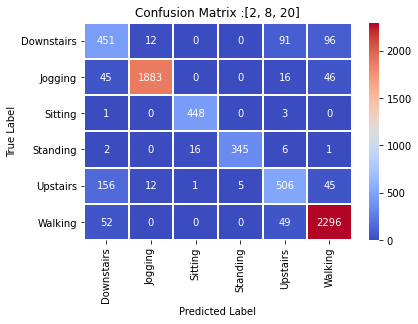


--- Classification report for test data [2, 8, 20]---

              precision    recall  f1-score   support

           0       0.64      0.69      0.66       650
           1       0.99      0.95      0.97      1990
           2       0.96      0.99      0.98       452
           3       0.99      0.93      0.96       370
           4       0.75      0.70      0.72       725
           5       0.92      0.96      0.94      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.87      0.87      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_49 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 79, 10)            70        
________________________________________________

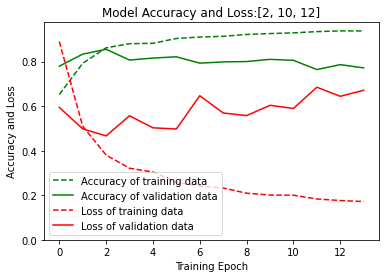


--- Check against test data ---

6584/6584 [==============================] - 2s 298us/step

Accuracy on test data: 0.89

Loss on test data: 0.36

--- Confusion matrix for test data ---



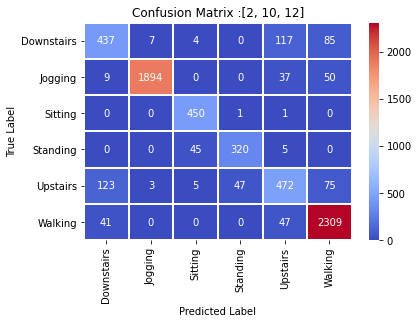


--- Classification report for test data [2, 10, 12]---

              precision    recall  f1-score   support

           0       0.72      0.67      0.69       650
           1       0.99      0.95      0.97      1990
           2       0.89      1.00      0.94       452
           3       0.87      0.86      0.87       370
           4       0.70      0.65      0.67       725
           5       0.92      0.96      0.94      2397

    accuracy                           0.89      6584
   macro avg       0.85      0.85      0.85      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_50 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_102 (Conv1D)          (None, 79, 10)            70        
_______________________________________________

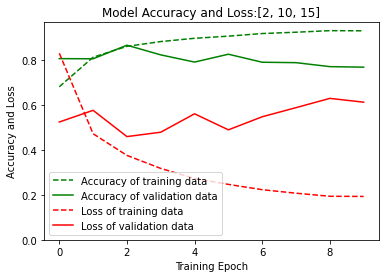


--- Check against test data ---

6584/6584 [==============================] - 2s 326us/step

Accuracy on test data: 0.90

Loss on test data: 0.34

--- Confusion matrix for test data ---



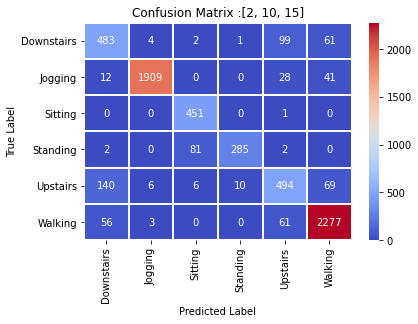


--- Classification report for test data [2, 10, 15]---

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       650
           1       0.99      0.96      0.98      1990
           2       0.84      1.00      0.91       452
           3       0.96      0.77      0.86       370
           4       0.72      0.68      0.70       725
           5       0.93      0.95      0.94      2397

    accuracy                           0.90      6584
   macro avg       0.86      0.85      0.85      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_51 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 79, 10)            70        
_______________________________________________

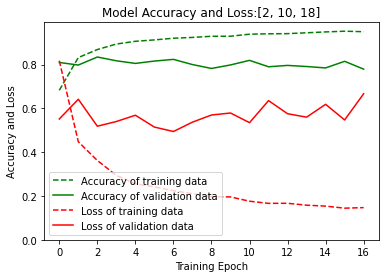


--- Check against test data ---

6584/6584 [==============================] - 2s 352us/step

Accuracy on test data: 0.90

Loss on test data: 0.36

--- Confusion matrix for test data ---



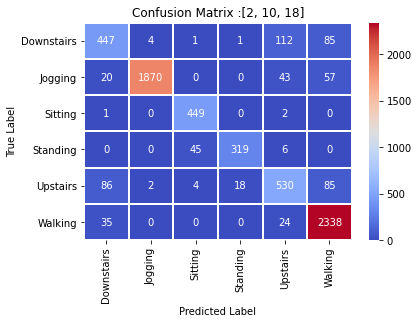


--- Classification report for test data [2, 10, 18]---

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       650
           1       1.00      0.94      0.97      1990
           2       0.90      0.99      0.94       452
           3       0.94      0.86      0.90       370
           4       0.74      0.73      0.74       725
           5       0.91      0.98      0.94      2397

    accuracy                           0.90      6584
   macro avg       0.87      0.86      0.87      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_52 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_108 (Conv1D)          (None, 79, 10)            70        
_______________________________________________

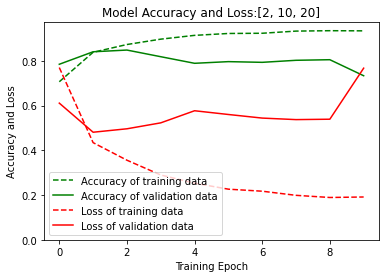


--- Check against test data ---

6584/6584 [==============================] - 2s 369us/step

Accuracy on test data: 0.86

Loss on test data: 0.47

--- Confusion matrix for test data ---



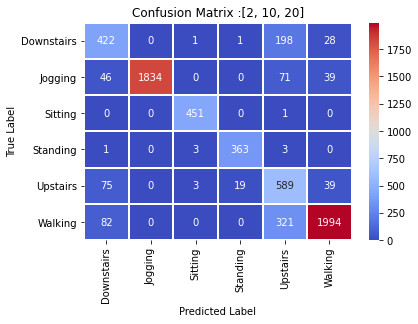


--- Classification report for test data [2, 10, 20]---

              precision    recall  f1-score   support

           0       0.67      0.65      0.66       650
           1       1.00      0.92      0.96      1990
           2       0.98      1.00      0.99       452
           3       0.95      0.98      0.96       370
           4       0.50      0.81      0.62       725
           5       0.95      0.83      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.84      0.87      0.85      6584
weighted avg       0.89      0.86      0.87      6584

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_53 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 79, 10)            70        
_______________________________________________

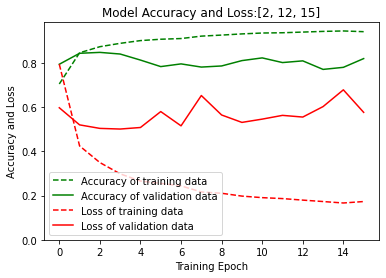


--- Check against test data ---

6584/6584 [==============================] - 2s 307us/step

Accuracy on test data: 0.89

Loss on test data: 0.39

--- Confusion matrix for test data ---



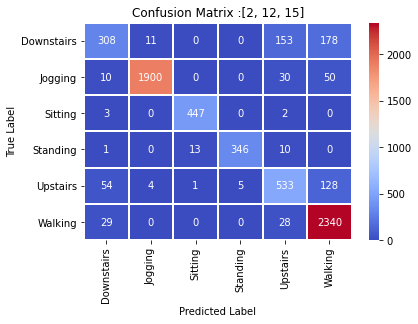


--- Classification report for test data [2, 12, 15]---

              precision    recall  f1-score   support

           0       0.76      0.47      0.58       650
           1       0.99      0.95      0.97      1990
           2       0.97      0.99      0.98       452
           3       0.99      0.94      0.96       370
           4       0.71      0.74      0.72       725
           5       0.87      0.98      0.92      2397

    accuracy                           0.89      6584
   macro avg       0.88      0.84      0.86      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_54 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_114 (Conv1D)          (None, 79, 10)            70        
_______________________________________________

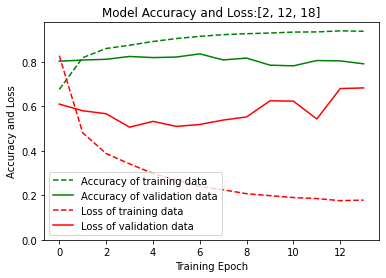


--- Check against test data ---

6584/6584 [==============================] - 2s 337us/step

Accuracy on test data: 0.89

Loss on test data: 0.40

--- Confusion matrix for test data ---



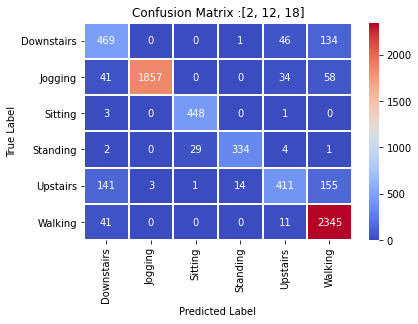


--- Classification report for test data [2, 12, 18]---

              precision    recall  f1-score   support

           0       0.67      0.72      0.70       650
           1       1.00      0.93      0.96      1990
           2       0.94      0.99      0.96       452
           3       0.96      0.90      0.93       370
           4       0.81      0.57      0.67       725
           5       0.87      0.98      0.92      2397

    accuracy                           0.89      6584
   macro avg       0.87      0.85      0.86      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_55 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_117 (Conv1D)          (None, 79, 10)            70        
_______________________________________________

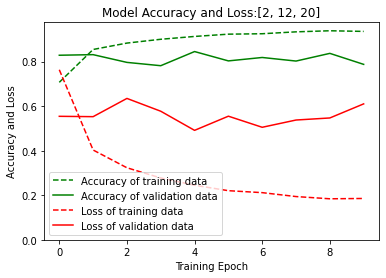


--- Check against test data ---

6584/6584 [==============================] - 2s 354us/step

Accuracy on test data: 0.90

Loss on test data: 0.36

--- Confusion matrix for test data ---



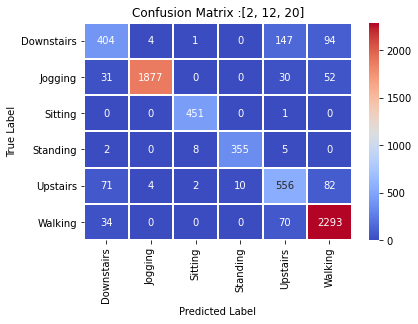


--- Classification report for test data [2, 12, 20]---

              precision    recall  f1-score   support

           0       0.75      0.62      0.68       650
           1       1.00      0.94      0.97      1990
           2       0.98      1.00      0.99       452
           3       0.97      0.96      0.97       370
           4       0.69      0.77      0.72       725
           5       0.91      0.96      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.87      0.88      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_56 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_120 (Conv1D)          (None, 79, 10)            70        
_______________________________________________

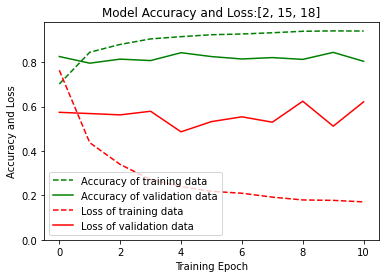


--- Check against test data ---

6584/6584 [==============================] - 2s 329us/step

Accuracy on test data: 0.87

Loss on test data: 0.41

--- Confusion matrix for test data ---



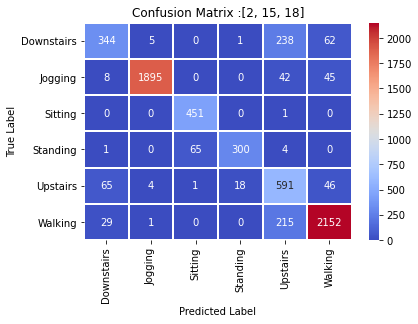


--- Classification report for test data [2, 15, 18]---

              precision    recall  f1-score   support

           0       0.77      0.53      0.63       650
           1       0.99      0.95      0.97      1990
           2       0.87      1.00      0.93       452
           3       0.94      0.81      0.87       370
           4       0.54      0.82      0.65       725
           5       0.93      0.90      0.92      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.83      0.83      6584
weighted avg       0.89      0.87      0.87      6584

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_57 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 79, 10)            70        
_______________________________________________

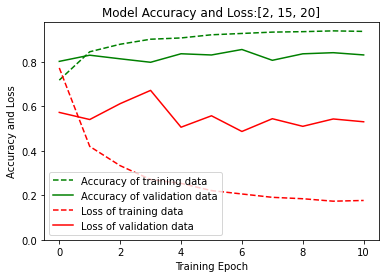


--- Check against test data ---

6584/6584 [==============================] - 2s 366us/step

Accuracy on test data: 0.90

Loss on test data: 0.36

--- Confusion matrix for test data ---



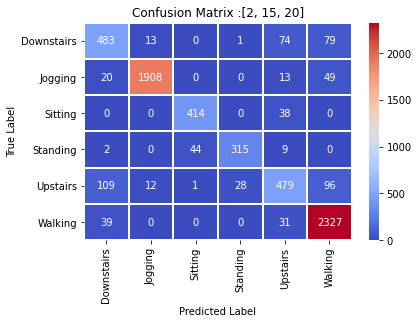


--- Classification report for test data [2, 15, 20]---

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       650
           1       0.99      0.96      0.97      1990
           2       0.90      0.92      0.91       452
           3       0.92      0.85      0.88       370
           4       0.74      0.66      0.70       725
           5       0.91      0.97      0.94      2397

    accuracy                           0.90      6584
   macro avg       0.87      0.85      0.86      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_58 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_126 (Conv1D)          (None, 79, 10)            70        
_______________________________________________

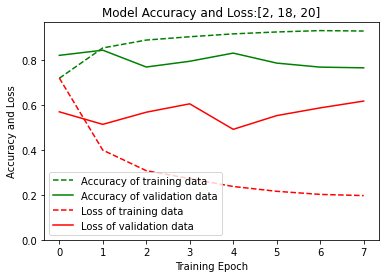


--- Check against test data ---

6584/6584 [==============================] - 2s 339us/step

Accuracy on test data: 0.90

Loss on test data: 0.37

--- Confusion matrix for test data ---



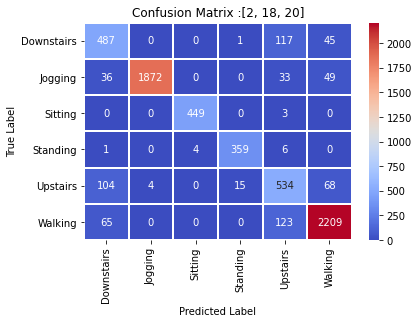


--- Classification report for test data [2, 18, 20]---

              precision    recall  f1-score   support

           0       0.70      0.75      0.73       650
           1       1.00      0.94      0.97      1990
           2       0.99      0.99      0.99       452
           3       0.96      0.97      0.96       370
           4       0.65      0.74      0.69       725
           5       0.93      0.92      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.87      0.89      0.88      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_59 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 76, 10)            160       
_______________________________________________

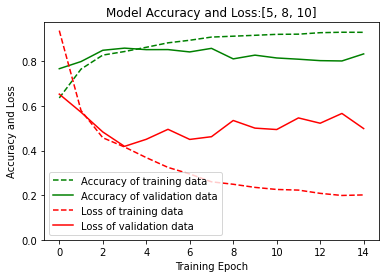


--- Check against test data ---

6584/6584 [==============================] - 2s 245us/step

Accuracy on test data: 0.88

Loss on test data: 0.42

--- Confusion matrix for test data ---



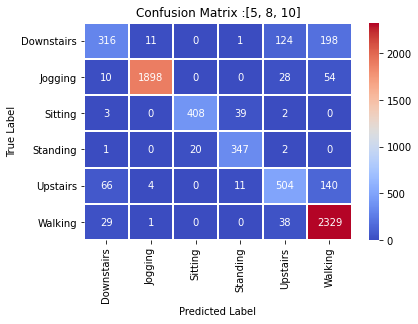


--- Classification report for test data [5, 8, 10]---

              precision    recall  f1-score   support

           0       0.74      0.49      0.59       650
           1       0.99      0.95      0.97      1990
           2       0.95      0.90      0.93       452
           3       0.87      0.94      0.90       370
           4       0.72      0.70      0.71       725
           5       0.86      0.97      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.82      0.83      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_60 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_132 (Conv1D)          (None, 76, 10)            160       
________________________________________________

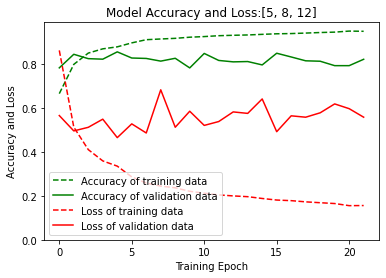


--- Check against test data ---

6584/6584 [==============================] - 2s 267us/step

Accuracy on test data: 0.91

Loss on test data: 0.33

--- Confusion matrix for test data ---



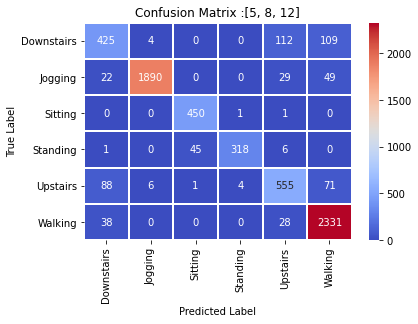


--- Classification report for test data [5, 8, 12]---

              precision    recall  f1-score   support

           0       0.74      0.65      0.69       650
           1       0.99      0.95      0.97      1990
           2       0.91      1.00      0.95       452
           3       0.98      0.86      0.92       370
           4       0.76      0.77      0.76       725
           5       0.91      0.97      0.94      2397

    accuracy                           0.91      6584
   macro avg       0.88      0.87      0.87      6584
weighted avg       0.91      0.91      0.91      6584

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_61 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 76, 10)            160       
________________________________________________

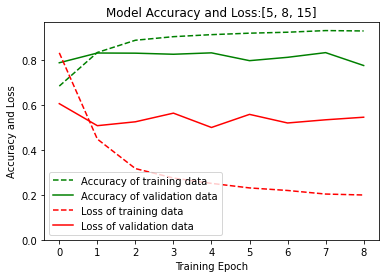


--- Check against test data ---

6584/6584 [==============================] - 2s 301us/step

Accuracy on test data: 0.90

Loss on test data: 0.33

--- Confusion matrix for test data ---



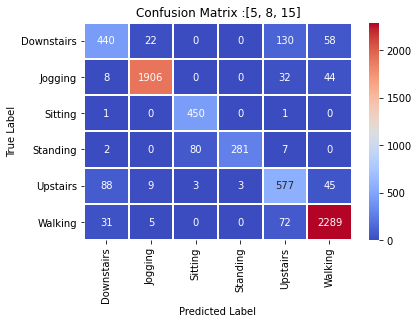


--- Classification report for test data [5, 8, 15]---

              precision    recall  f1-score   support

           0       0.77      0.68      0.72       650
           1       0.98      0.96      0.97      1990
           2       0.84      1.00      0.91       452
           3       0.99      0.76      0.86       370
           4       0.70      0.80      0.75       725
           5       0.94      0.95      0.95      2397

    accuracy                           0.90      6584
   macro avg       0.87      0.86      0.86      6584
weighted avg       0.91      0.90      0.90      6584

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_62 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_138 (Conv1D)          (None, 76, 10)            160       
________________________________________________

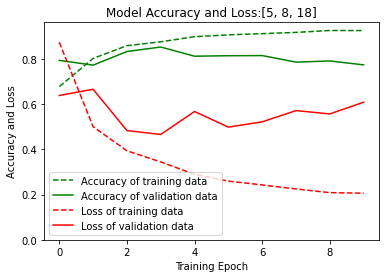


--- Check against test data ---

6584/6584 [==============================] - 2s 327us/step

Accuracy on test data: 0.90

Loss on test data: 0.36

--- Confusion matrix for test data ---



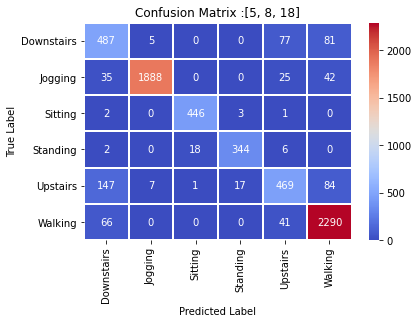


--- Classification report for test data [5, 8, 18]---

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       650
           1       0.99      0.95      0.97      1990
           2       0.96      0.99      0.97       452
           3       0.95      0.93      0.94       370
           4       0.76      0.65      0.70       725
           5       0.92      0.96      0.94      2397

    accuracy                           0.90      6584
   macro avg       0.87      0.87      0.87      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_63 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 76, 10)            160       
________________________________________________

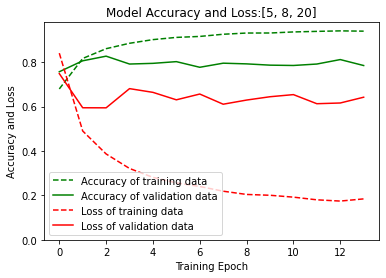


--- Check against test data ---

6584/6584 [==============================] - 2s 345us/step

Accuracy on test data: 0.90

Loss on test data: 0.35

--- Confusion matrix for test data ---



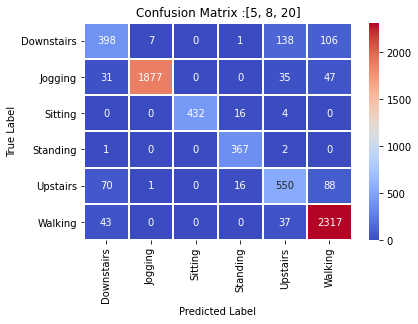


--- Classification report for test data [5, 8, 20]---

              precision    recall  f1-score   support

           0       0.73      0.61      0.67       650
           1       1.00      0.94      0.97      1990
           2       1.00      0.96      0.98       452
           3       0.92      0.99      0.95       370
           4       0.72      0.76      0.74       725
           5       0.91      0.97      0.94      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.87      0.87      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_64 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_144 (Conv1D)          (None, 76, 10)            160       
________________________________________________

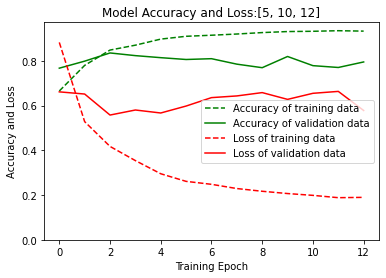


--- Check against test data ---

6584/6584 [==============================] - 2s 252us/step

Accuracy on test data: 0.91

Loss on test data: 0.33

--- Confusion matrix for test data ---



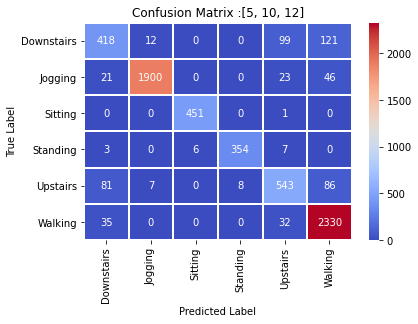


--- Classification report for test data [5, 10, 12]---

              precision    recall  f1-score   support

           0       0.75      0.64      0.69       650
           1       0.99      0.95      0.97      1990
           2       0.99      1.00      0.99       452
           3       0.98      0.96      0.97       370
           4       0.77      0.75      0.76       725
           5       0.90      0.97      0.94      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.91      0.91      0.91      6584

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_65 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_147 (Conv1D)          (None, 76, 10)            160       
_______________________________________________

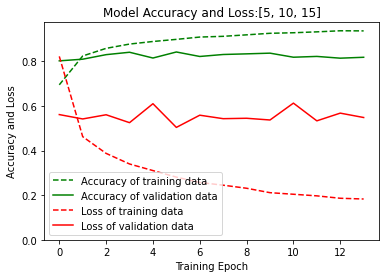


--- Check against test data ---

6584/6584 [==============================] - 2s 289us/step

Accuracy on test data: 0.90

Loss on test data: 0.37

--- Confusion matrix for test data ---



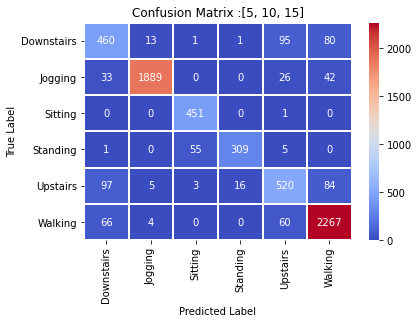


--- Classification report for test data [5, 10, 15]---

              precision    recall  f1-score   support

           0       0.70      0.71      0.70       650
           1       0.99      0.95      0.97      1990
           2       0.88      1.00      0.94       452
           3       0.95      0.84      0.89       370
           4       0.74      0.72      0.73       725
           5       0.92      0.95      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.86      0.86      0.86      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_66 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_150 (Conv1D)          (None, 76, 10)            160       
_______________________________________________

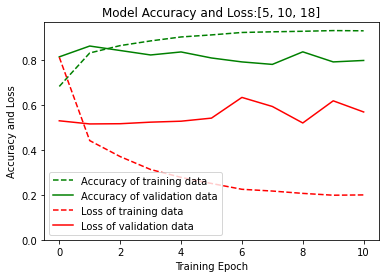


--- Check against test data ---

6584/6584 [==============================] - 2s 313us/step

Accuracy on test data: 0.90

Loss on test data: 0.36

--- Confusion matrix for test data ---



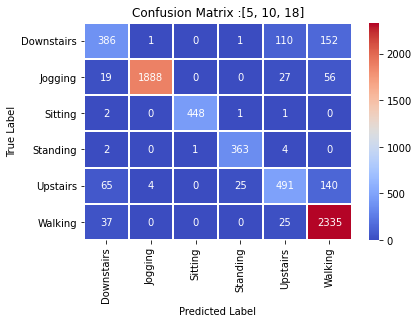


--- Classification report for test data [5, 10, 18]---

              precision    recall  f1-score   support

           0       0.76      0.59      0.66       650
           1       1.00      0.95      0.97      1990
           2       1.00      0.99      0.99       452
           3       0.93      0.98      0.96       370
           4       0.75      0.68      0.71       725
           5       0.87      0.97      0.92      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.86      0.87      6584
weighted avg       0.90      0.90      0.89      6584

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_67 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_153 (Conv1D)          (None, 76, 10)            160       
_______________________________________________

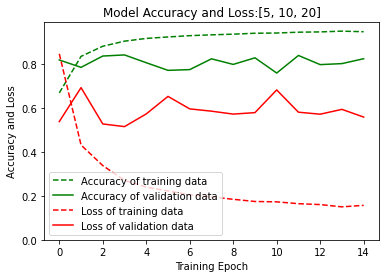


--- Check against test data ---

6584/6584 [==============================] - 2s 365us/step

Accuracy on test data: 0.91

Loss on test data: 0.37

--- Confusion matrix for test data ---



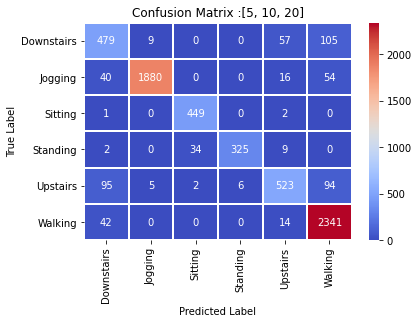


--- Classification report for test data [5, 10, 20]---

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       650
           1       0.99      0.94      0.97      1990
           2       0.93      0.99      0.96       452
           3       0.98      0.88      0.93       370
           4       0.84      0.72      0.78       725
           5       0.90      0.98      0.94      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.88      0.88      6584
weighted avg       0.91      0.91      0.91      6584

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_68 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_156 (Conv1D)          (None, 76, 10)            160       
_______________________________________________

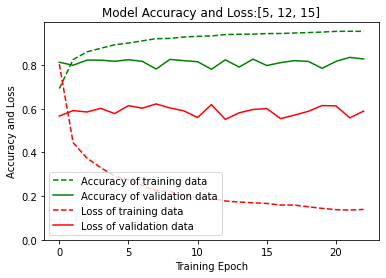


--- Check against test data ---

6584/6584 [==============================] - 2s 305us/step

Accuracy on test data: 0.90

Loss on test data: 0.37

--- Confusion matrix for test data ---



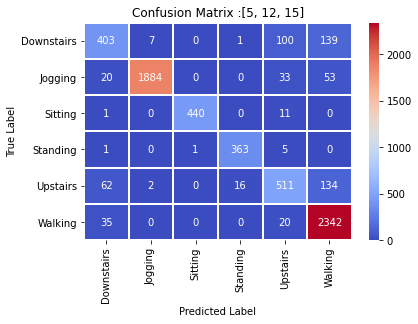


--- Classification report for test data [5, 12, 15]---

              precision    recall  f1-score   support

           0       0.77      0.62      0.69       650
           1       1.00      0.95      0.97      1990
           2       1.00      0.97      0.99       452
           3       0.96      0.98      0.97       370
           4       0.75      0.70      0.73       725
           5       0.88      0.98      0.92      2397

    accuracy                           0.90      6584
   macro avg       0.89      0.87      0.88      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_69 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_159 (Conv1D)          (None, 76, 10)            160       
_______________________________________________

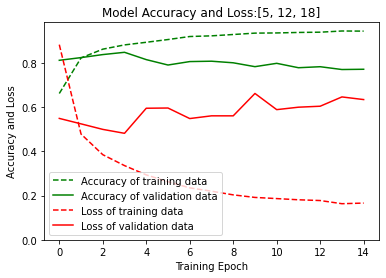


--- Check against test data ---

6584/6584 [==============================] - 2s 335us/step

Accuracy on test data: 0.90

Loss on test data: 0.35

--- Confusion matrix for test data ---



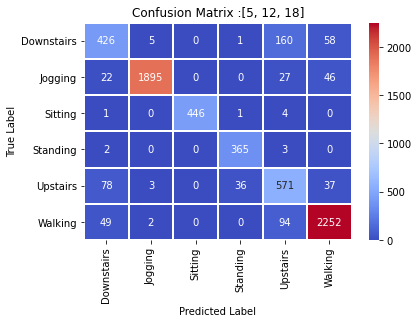


--- Classification report for test data [5, 12, 18]---

              precision    recall  f1-score   support

           0       0.74      0.66      0.69       650
           1       0.99      0.95      0.97      1990
           2       1.00      0.99      0.99       452
           3       0.91      0.99      0.94       370
           4       0.66      0.79      0.72       725
           5       0.94      0.94      0.94      2397

    accuracy                           0.90      6584
   macro avg       0.87      0.88      0.88      6584
weighted avg       0.91      0.90      0.91      6584

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_70 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_162 (Conv1D)          (None, 76, 10)            160       
_______________________________________________

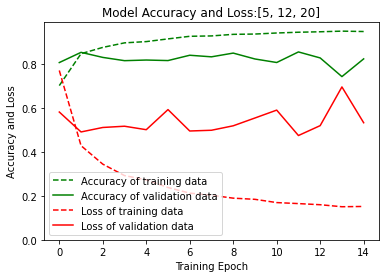


--- Check against test data ---

6584/6584 [==============================] - 2s 358us/step

Accuracy on test data: 0.91

Loss on test data: 0.35

--- Confusion matrix for test data ---



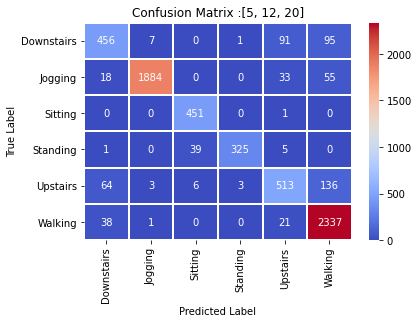


--- Classification report for test data [5, 12, 20]---

              precision    recall  f1-score   support

           0       0.79      0.70      0.74       650
           1       0.99      0.95      0.97      1990
           2       0.91      1.00      0.95       452
           3       0.99      0.88      0.93       370
           4       0.77      0.71      0.74       725
           5       0.89      0.97      0.93      2397

    accuracy                           0.91      6584
   macro avg       0.89      0.87      0.88      6584
weighted avg       0.91      0.91      0.90      6584

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_71 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_165 (Conv1D)          (None, 76, 10)            160       
_______________________________________________

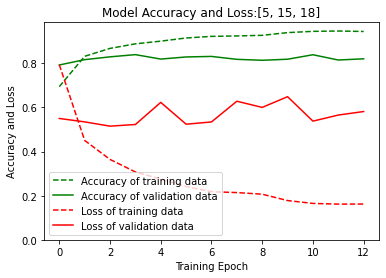


--- Check against test data ---

6584/6584 [==============================] - 2s 338us/step

Accuracy on test data: 0.89

Loss on test data: 0.41

--- Confusion matrix for test data ---



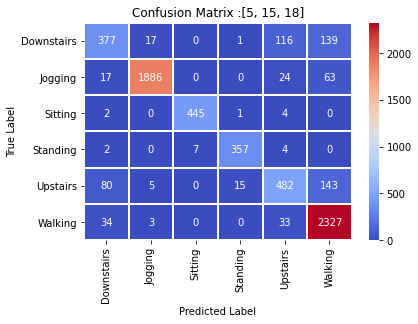


--- Classification report for test data [5, 15, 18]---

              precision    recall  f1-score   support

           0       0.74      0.58      0.65       650
           1       0.99      0.95      0.97      1990
           2       0.98      0.98      0.98       452
           3       0.95      0.96      0.96       370
           4       0.73      0.66      0.69       725
           5       0.87      0.97      0.92      2397

    accuracy                           0.89      6584
   macro avg       0.88      0.85      0.86      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_72 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_168 (Conv1D)          (None, 76, 10)            160       
_______________________________________________

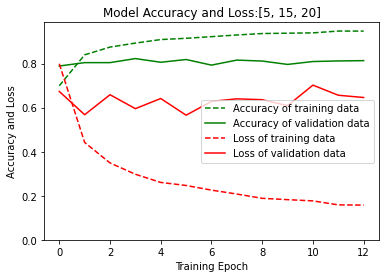


--- Check against test data ---

6584/6584 [==============================] - 2s 330us/step

Accuracy on test data: 0.89

Loss on test data: 0.39

--- Confusion matrix for test data ---



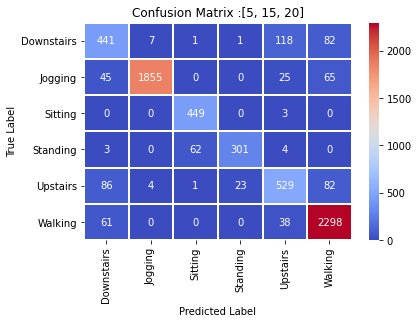


--- Classification report for test data [5, 15, 20]---

              precision    recall  f1-score   support

           0       0.69      0.68      0.69       650
           1       0.99      0.93      0.96      1990
           2       0.88      0.99      0.93       452
           3       0.93      0.81      0.87       370
           4       0.74      0.73      0.73       725
           5       0.91      0.96      0.93      2397

    accuracy                           0.89      6584
   macro avg       0.86      0.85      0.85      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_73 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_171 (Conv1D)          (None, 76, 10)            160       
_______________________________________________

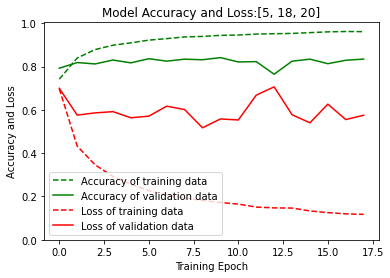


--- Check against test data ---

6584/6584 [==============================] - 2s 330us/step

Accuracy on test data: 0.91

Loss on test data: 0.34

--- Confusion matrix for test data ---



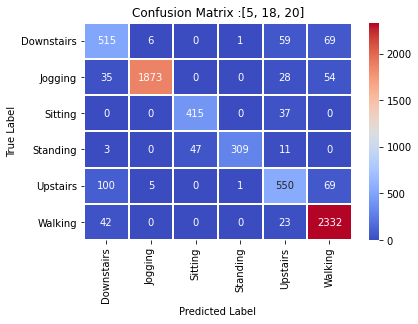


--- Classification report for test data [5, 18, 20]---

              precision    recall  f1-score   support

           0       0.74      0.79      0.77       650
           1       0.99      0.94      0.97      1990
           2       0.90      0.92      0.91       452
           3       0.99      0.84      0.91       370
           4       0.78      0.76      0.77       725
           5       0.92      0.97      0.95      2397

    accuracy                           0.91      6584
   macro avg       0.89      0.87      0.88      6584
weighted avg       0.91      0.91      0.91      6584

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_74 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_174 (Conv1D)          (None, 73, 10)            250       
_______________________________________________

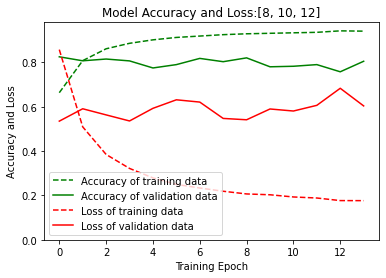


--- Check against test data ---

6584/6584 [==============================] - 2s 260us/step

Accuracy on test data: 0.89

Loss on test data: 0.40

--- Confusion matrix for test data ---



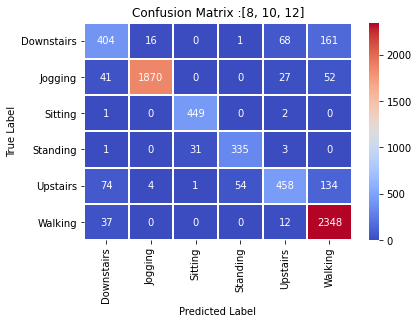


--- Classification report for test data [8, 10, 12]---

              precision    recall  f1-score   support

           0       0.72      0.62      0.67       650
           1       0.99      0.94      0.96      1990
           2       0.93      0.99      0.96       452
           3       0.86      0.91      0.88       370
           4       0.80      0.63      0.71       725
           5       0.87      0.98      0.92      2397

    accuracy                           0.89      6584
   macro avg       0.86      0.85      0.85      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_75 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_177 (Conv1D)          (None, 73, 10)            250       
_______________________________________________

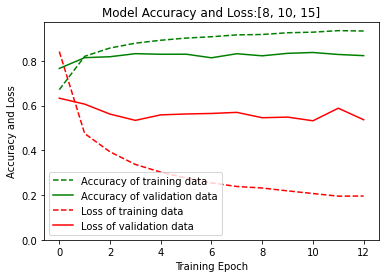


--- Check against test data ---

6584/6584 [==============================] - 2s 285us/step

Accuracy on test data: 0.90

Loss on test data: 0.35

--- Confusion matrix for test data ---



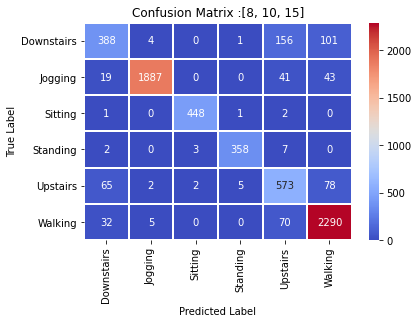


--- Classification report for test data [8, 10, 15]---

              precision    recall  f1-score   support

           0       0.77      0.60      0.67       650
           1       0.99      0.95      0.97      1990
           2       0.99      0.99      0.99       452
           3       0.98      0.97      0.97       370
           4       0.67      0.79      0.73       725
           5       0.91      0.96      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.89      0.87      0.88      6584
weighted avg       0.91      0.90      0.90      6584

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_76 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_180 (Conv1D)          (None, 73, 10)            250       
_______________________________________________

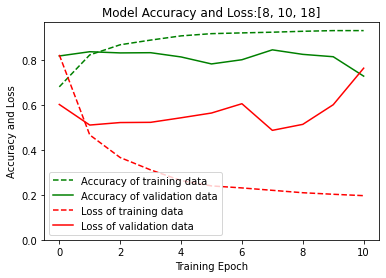


--- Check against test data ---

6584/6584 [==============================] - 2s 319us/step

Accuracy on test data: 0.88

Loss on test data: 0.39

--- Confusion matrix for test data ---



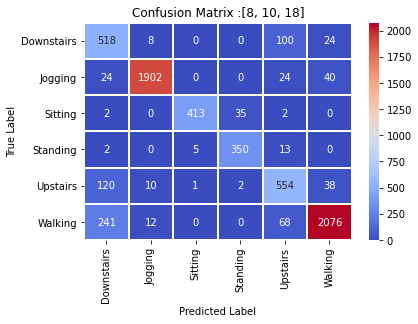


--- Classification report for test data [8, 10, 18]---

              precision    recall  f1-score   support

           0       0.57      0.80      0.67       650
           1       0.98      0.96      0.97      1990
           2       0.99      0.91      0.95       452
           3       0.90      0.95      0.92       370
           4       0.73      0.76      0.75       725
           5       0.95      0.87      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.85      0.87      0.86      6584
weighted avg       0.90      0.88      0.89      6584

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_77 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 73, 10)            250       
_______________________________________________

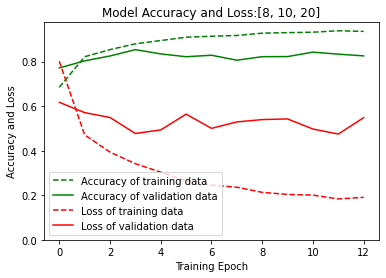


--- Check against test data ---

6584/6584 [==============================] - 2s 345us/step

Accuracy on test data: 0.89

Loss on test data: 0.43

--- Confusion matrix for test data ---



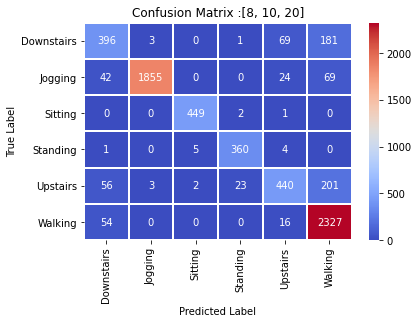


--- Classification report for test data [8, 10, 20]---

              precision    recall  f1-score   support

           0       0.72      0.61      0.66       650
           1       1.00      0.93      0.96      1990
           2       0.98      0.99      0.99       452
           3       0.93      0.97      0.95       370
           4       0.79      0.61      0.69       725
           5       0.84      0.97      0.90      2397

    accuracy                           0.89      6584
   macro avg       0.88      0.85      0.86      6584
weighted avg       0.88      0.89      0.88      6584

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_78 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_186 (Conv1D)          (None, 73, 10)            250       
_______________________________________________

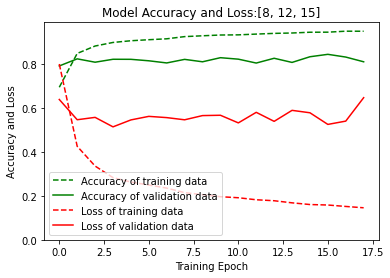


--- Check against test data ---

6584/6584 [==============================] - 2s 283us/step

Accuracy on test data: 0.91

Loss on test data: 0.36

--- Confusion matrix for test data ---



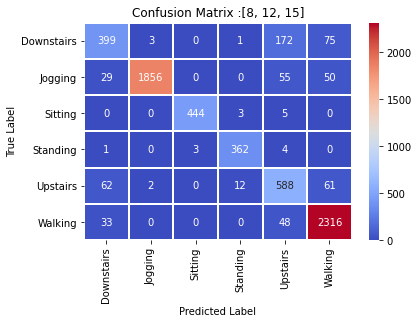


--- Classification report for test data [8, 12, 15]---

              precision    recall  f1-score   support

           0       0.76      0.61      0.68       650
           1       1.00      0.93      0.96      1990
           2       0.99      0.98      0.99       452
           3       0.96      0.98      0.97       370
           4       0.67      0.81      0.74       725
           5       0.93      0.97      0.95      2397

    accuracy                           0.91      6584
   macro avg       0.88      0.88      0.88      6584
weighted avg       0.91      0.91      0.91      6584

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_79 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_189 (Conv1D)          (None, 73, 10)            250       
_______________________________________________

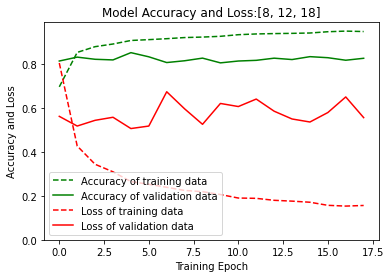


--- Check against test data ---

6584/6584 [==============================] - 2s 312us/step

Accuracy on test data: 0.90

Loss on test data: 0.37

--- Confusion matrix for test data ---



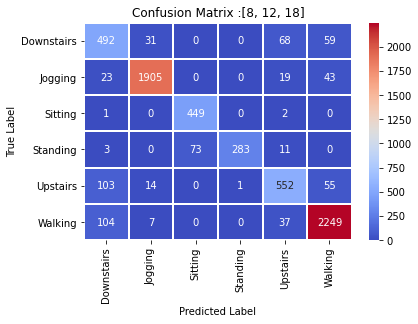


--- Classification report for test data [8, 12, 18]---

              precision    recall  f1-score   support

           0       0.68      0.76      0.72       650
           1       0.97      0.96      0.97      1990
           2       0.86      0.99      0.92       452
           3       1.00      0.76      0.87       370
           4       0.80      0.76      0.78       725
           5       0.93      0.94      0.94      2397

    accuracy                           0.90      6584
   macro avg       0.87      0.86      0.86      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_80 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_192 (Conv1D)          (None, 73, 10)            250       
_______________________________________________

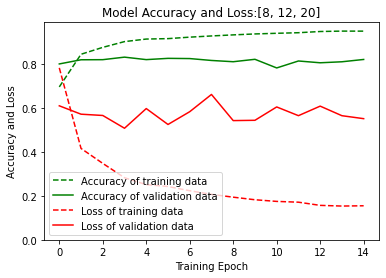


--- Check against test data ---

6584/6584 [==============================] - 2s 315us/step

Accuracy on test data: 0.91

Loss on test data: 0.33

--- Confusion matrix for test data ---



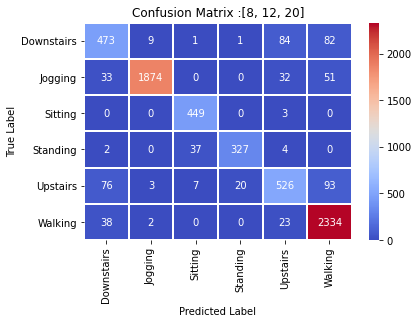


--- Classification report for test data [8, 12, 20]---

              precision    recall  f1-score   support

           0       0.76      0.73      0.74       650
           1       0.99      0.94      0.97      1990
           2       0.91      0.99      0.95       452
           3       0.94      0.88      0.91       370
           4       0.78      0.73      0.75       725
           5       0.91      0.97      0.94      2397

    accuracy                           0.91      6584
   macro avg       0.88      0.87      0.88      6584
weighted avg       0.91      0.91      0.91      6584

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_81 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_195 (Conv1D)          (None, 73, 10)            250       
_______________________________________________

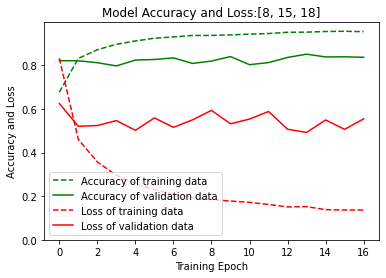


--- Check against test data ---

6584/6584 [==============================] - 2s 292us/step

Accuracy on test data: 0.89

Loss on test data: 0.43

--- Confusion matrix for test data ---



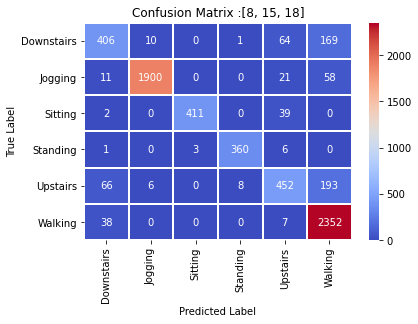


--- Classification report for test data [8, 15, 18]---

              precision    recall  f1-score   support

           0       0.77      0.62      0.69       650
           1       0.99      0.95      0.97      1990
           2       0.99      0.91      0.95       452
           3       0.98      0.97      0.97       370
           4       0.77      0.62      0.69       725
           5       0.85      0.98      0.91      2397

    accuracy                           0.89      6584
   macro avg       0.89      0.84      0.86      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_82 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_198 (Conv1D)          (None, 73, 10)            250       
_______________________________________________

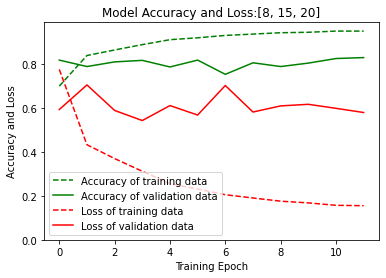


--- Check against test data ---

6584/6584 [==============================] - 2s 322us/step

Accuracy on test data: 0.89

Loss on test data: 0.41

--- Confusion matrix for test data ---



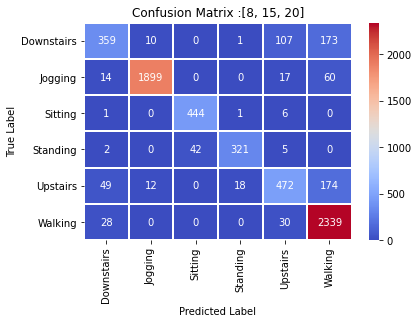


--- Classification report for test data [8, 15, 20]---

              precision    recall  f1-score   support

           0       0.79      0.55      0.65       650
           1       0.99      0.95      0.97      1990
           2       0.91      0.98      0.95       452
           3       0.94      0.87      0.90       370
           4       0.74      0.65      0.69       725
           5       0.85      0.98      0.91      2397

    accuracy                           0.89      6584
   macro avg       0.87      0.83      0.85      6584
weighted avg       0.88      0.89      0.88      6584

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_83 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_201 (Conv1D)          (None, 73, 10)            250       
_______________________________________________

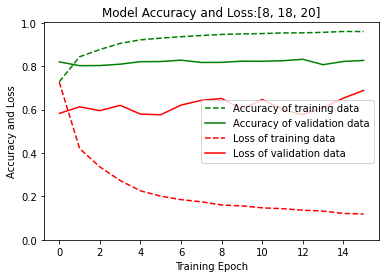


--- Check against test data ---

6584/6584 [==============================] - 2s 286us/step

Accuracy on test data: 0.88

Loss on test data: 0.45

--- Confusion matrix for test data ---



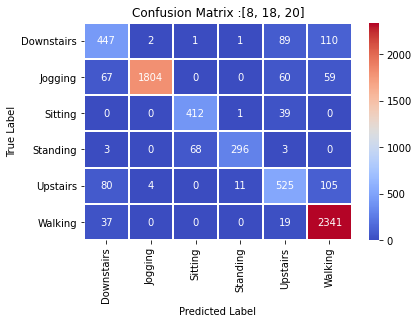


--- Classification report for test data [8, 18, 20]---

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       650
           1       1.00      0.91      0.95      1990
           2       0.86      0.91      0.88       452
           3       0.96      0.80      0.87       370
           4       0.71      0.72      0.72       725
           5       0.90      0.98      0.93      2397

    accuracy                           0.88      6584
   macro avg       0.85      0.83      0.84      6584
weighted avg       0.89      0.88      0.88      6584

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_84 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_204 (Conv1D)          (None, 71, 10)            310       
_______________________________________________

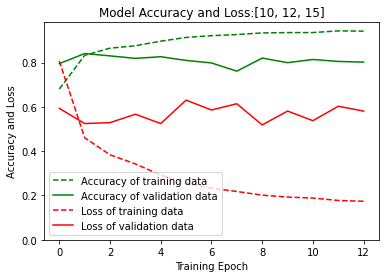


--- Check against test data ---

6584/6584 [==============================] - 2s 269us/step

Accuracy on test data: 0.89

Loss on test data: 0.40

--- Confusion matrix for test data ---



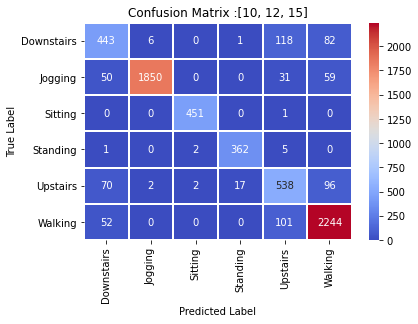


--- Classification report for test data [10, 12, 15]---

              precision    recall  f1-score   support

           0       0.72      0.68      0.70       650
           1       1.00      0.93      0.96      1990
           2       0.99      1.00      0.99       452
           3       0.95      0.98      0.97       370
           4       0.68      0.74      0.71       725
           5       0.90      0.94      0.92      2397

    accuracy                           0.89      6584
   macro avg       0.87      0.88      0.87      6584
weighted avg       0.90      0.89      0.90      6584

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_85 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 71, 10)            310       
______________________________________________

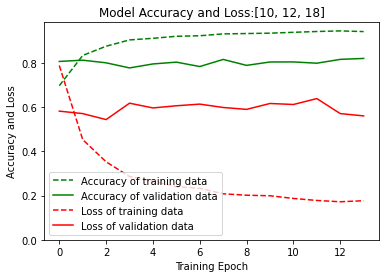


--- Check against test data ---

6584/6584 [==============================] - 2s 289us/step

Accuracy on test data: 0.89

Loss on test data: 0.38

--- Confusion matrix for test data ---



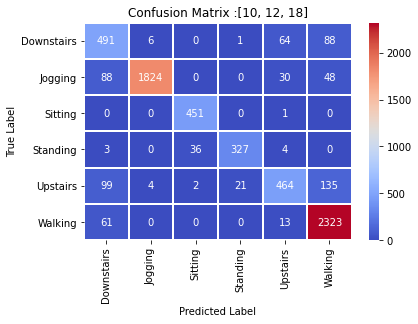


--- Classification report for test data [10, 12, 18]---

              precision    recall  f1-score   support

           0       0.66      0.76      0.71       650
           1       0.99      0.92      0.95      1990
           2       0.92      1.00      0.96       452
           3       0.94      0.88      0.91       370
           4       0.81      0.64      0.71       725
           5       0.90      0.97      0.93      2397

    accuracy                           0.89      6584
   macro avg       0.87      0.86      0.86      6584
weighted avg       0.90      0.89      0.89      6584

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_86 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_210 (Conv1D)          (None, 71, 10)            310       
______________________________________________

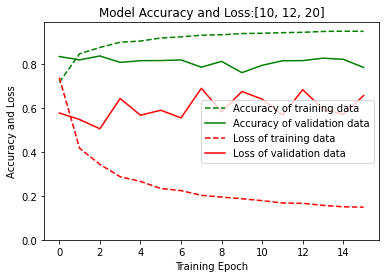


--- Check against test data ---

6584/6584 [==============================] - 2s 318us/step

Accuracy on test data: 0.90

Loss on test data: 0.35

--- Confusion matrix for test data ---



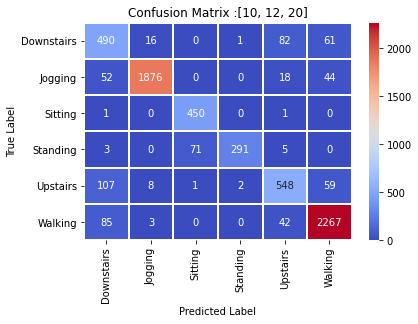


--- Classification report for test data [10, 12, 20]---

              precision    recall  f1-score   support

           0       0.66      0.75      0.71       650
           1       0.99      0.94      0.96      1990
           2       0.86      1.00      0.92       452
           3       0.99      0.79      0.88       370
           4       0.79      0.76      0.77       725
           5       0.93      0.95      0.94      2397

    accuracy                           0.90      6584
   macro avg       0.87      0.86      0.86      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_87 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_213 (Conv1D)          (None, 71, 10)            310       
______________________________________________

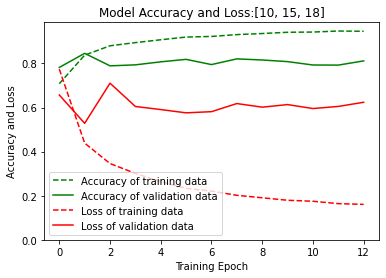


--- Check against test data ---

6584/6584 [==============================] - 2s 300us/step

Accuracy on test data: 0.91

Loss on test data: 0.34

--- Confusion matrix for test data ---



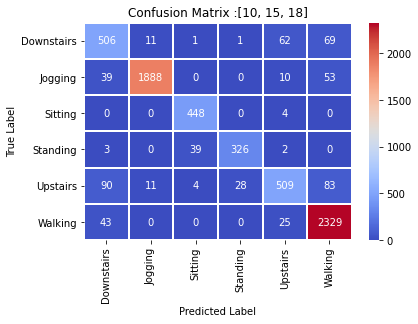


--- Classification report for test data [10, 15, 18]---

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       650
           1       0.99      0.95      0.97      1990
           2       0.91      0.99      0.95       452
           3       0.92      0.88      0.90       370
           4       0.83      0.70      0.76       725
           5       0.92      0.97      0.94      2397

    accuracy                           0.91      6584
   macro avg       0.89      0.88      0.88      6584
weighted avg       0.91      0.91      0.91      6584

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_88 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_216 (Conv1D)          (None, 71, 10)            310       
______________________________________________

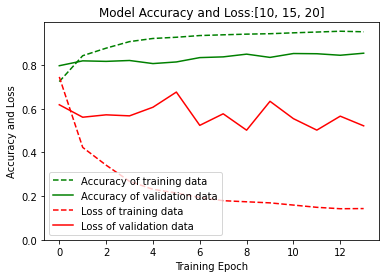


--- Check against test data ---

6584/6584 [==============================] - 2s 290us/step

Accuracy on test data: 0.89

Loss on test data: 0.36

--- Confusion matrix for test data ---



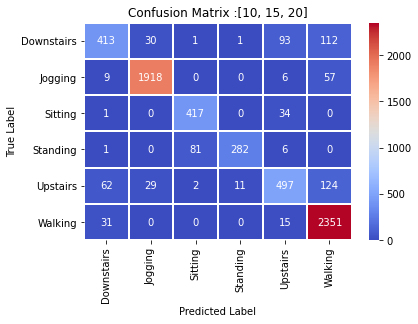


--- Classification report for test data [10, 15, 20]---

              precision    recall  f1-score   support

           0       0.80      0.64      0.71       650
           1       0.97      0.96      0.97      1990
           2       0.83      0.92      0.88       452
           3       0.96      0.76      0.85       370
           4       0.76      0.69      0.72       725
           5       0.89      0.98      0.93      2397

    accuracy                           0.89      6584
   macro avg       0.87      0.83      0.84      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_89 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_219 (Conv1D)          (None, 71, 10)            310       
______________________________________________

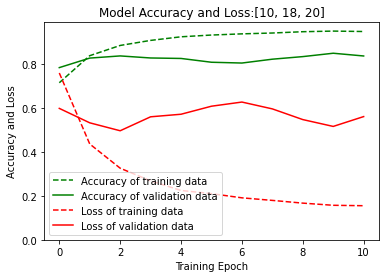


--- Check against test data ---

6584/6584 [==============================] - 2s 280us/step

Accuracy on test data: 0.88

Loss on test data: 0.44

--- Confusion matrix for test data ---



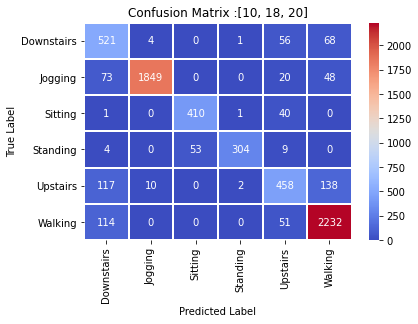


--- Classification report for test data [10, 18, 20]---

              precision    recall  f1-score   support

           0       0.63      0.80      0.70       650
           1       0.99      0.93      0.96      1990
           2       0.89      0.91      0.90       452
           3       0.99      0.82      0.90       370
           4       0.72      0.63      0.67       725
           5       0.90      0.93      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.85      0.84      0.84      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_90 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_222 (Conv1D)          (None, 69, 10)            370       
______________________________________________

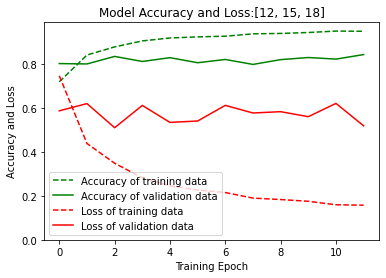


--- Check against test data ---

6584/6584 [==============================] - 2s 266us/step

Accuracy on test data: 0.89

Loss on test data: 0.39

--- Confusion matrix for test data ---



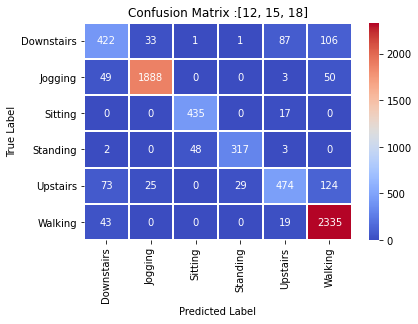


--- Classification report for test data [12, 15, 18]---

              precision    recall  f1-score   support

           0       0.72      0.65      0.68       650
           1       0.97      0.95      0.96      1990
           2       0.90      0.96      0.93       452
           3       0.91      0.86      0.88       370
           4       0.79      0.65      0.71       725
           5       0.89      0.97      0.93      2397

    accuracy                           0.89      6584
   macro avg       0.86      0.84      0.85      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_91 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_225 (Conv1D)          (None, 69, 10)            370       
______________________________________________

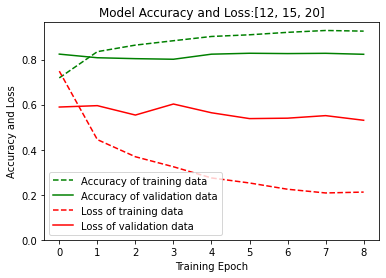


--- Check against test data ---

6584/6584 [==============================] - 2s 276us/step

Accuracy on test data: 0.89

Loss on test data: 0.39

--- Confusion matrix for test data ---



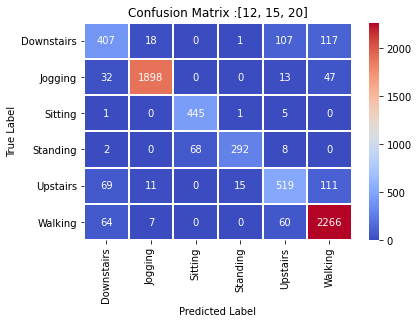


--- Classification report for test data [12, 15, 20]---

              precision    recall  f1-score   support

           0       0.71      0.63      0.66       650
           1       0.98      0.95      0.97      1990
           2       0.87      0.98      0.92       452
           3       0.94      0.79      0.86       370
           4       0.73      0.72      0.72       725
           5       0.89      0.95      0.92      2397

    accuracy                           0.89      6584
   macro avg       0.85      0.84      0.84      6584
weighted avg       0.88      0.89      0.88      6584

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_92 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_228 (Conv1D)          (None, 69, 10)            370       
______________________________________________

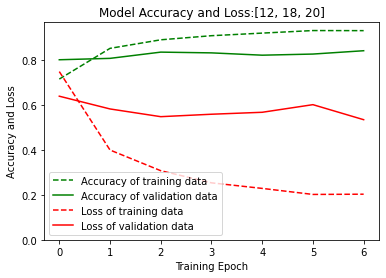


--- Check against test data ---

6584/6584 [==============================] - 2s 264us/step

Accuracy on test data: 0.88

Loss on test data: 0.42

--- Confusion matrix for test data ---



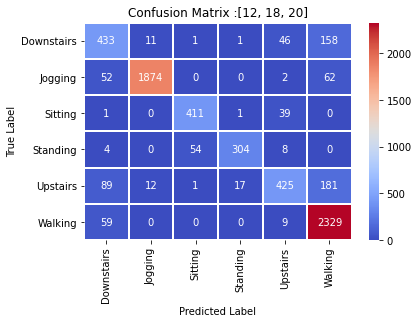


--- Classification report for test data [12, 18, 20]---

              precision    recall  f1-score   support

           0       0.68      0.67      0.67       650
           1       0.99      0.94      0.96      1990
           2       0.88      0.91      0.89       452
           3       0.94      0.82      0.88       370
           4       0.80      0.59      0.68       725
           5       0.85      0.97      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.82      0.83      6584
weighted avg       0.88      0.88      0.87      6584

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_93 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_231 (Conv1D)          (None, 66, 10)            460       
______________________________________________

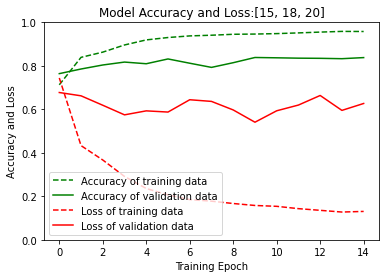


--- Check against test data ---

6584/6584 [==============================] - 2s 258us/step

Accuracy on test data: 0.89

Loss on test data: 0.51

--- Confusion matrix for test data ---



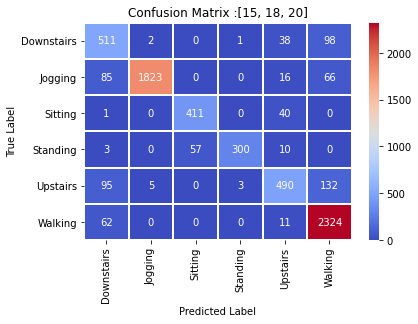


--- Classification report for test data [15, 18, 20]---

              precision    recall  f1-score   support

           0       0.68      0.79      0.73       650
           1       1.00      0.92      0.95      1990
           2       0.88      0.91      0.89       452
           3       0.99      0.81      0.89       370
           4       0.81      0.68      0.74       725
           5       0.89      0.97      0.93      2397

    accuracy                           0.89      6584
   macro avg       0.87      0.84      0.85      6584
weighted avg       0.90      0.89      0.89      6584



In [5]:
from itertools import combinations
lst_obj = [ 2,  5,  8, 10, 12, 15, 18, 20]
obj = {}
for no_l in range(1,4):
    arr_obj = []
    for ele in list(combinations(lst_obj,no_l)):
        arr_obj.append(call_model(list(ele)))
    obj[no_l] = arr_obj

In [6]:
obj

{1: [0.6828675866127014,
  0.7829586863517761,
  0.8124240636825562,
  0.8169805407524109,
  0.8207776546478271,
  0.8250303864479065,
  0.8286755681037903,
  0.818195641040802],
 2: [0.8503949046134949,
  0.8724179863929749,
  0.8819866180419922,
  0.8844167590141296,
  0.8783414363861084,
  0.8444714546203613,
  0.871051013469696,
  0.8765188455581665,
  0.8707472681999207,
  0.8756075501441956,
  0.8564702272415161,
  0.8832017183303833,
  0.8614823818206787,
  0.8810753226280212,
  0.8851761817932129,
  0.8617861270904541,
  0.8722661137580872,
  0.8623936772346497,
  0.8660388588905334,
  0.8798602819442749,
  0.8669501543045044,
  0.8771263957023621,
  0.8756075501441956,
  0.8806197047233582,
  0.8746962547302246,
  0.871051013469696,
  0.870595395565033,
  0.861330509185791],
 3: [0.871962308883667,
  0.8778857588768005,
  0.8824422955513,
  0.874088704586029,
  0.8573815226554871,
  0.89702308177948,
  0.887302577495575,
  0.8693802952766418,
  0.9021871089935303,
  0.90188336

In [7]:
from itertools import combinations
lst_obj = [ 2,  5,  8, 10, 12, 15, 18, 20]
obj_tmp = {}
for no_l in range(1,4):
    arr_obj = []
    for ele in list(combinations(lst_obj,no_l)):
        arr_obj.append(list(ele))
    obj_tmp[no_l] = arr_obj

In [8]:
obj_tmp

{1: [[2], [5], [8], [10], [12], [15], [18], [20]],
 2: [[2, 5],
  [2, 8],
  [2, 10],
  [2, 12],
  [2, 15],
  [2, 18],
  [2, 20],
  [5, 8],
  [5, 10],
  [5, 12],
  [5, 15],
  [5, 18],
  [5, 20],
  [8, 10],
  [8, 12],
  [8, 15],
  [8, 18],
  [8, 20],
  [10, 12],
  [10, 15],
  [10, 18],
  [10, 20],
  [12, 15],
  [12, 18],
  [12, 20],
  [15, 18],
  [15, 20],
  [18, 20]],
 3: [[2, 5, 8],
  [2, 5, 10],
  [2, 5, 12],
  [2, 5, 15],
  [2, 5, 18],
  [2, 5, 20],
  [2, 8, 10],
  [2, 8, 12],
  [2, 8, 15],
  [2, 8, 18],
  [2, 8, 20],
  [2, 10, 12],
  [2, 10, 15],
  [2, 10, 18],
  [2, 10, 20],
  [2, 12, 15],
  [2, 12, 18],
  [2, 12, 20],
  [2, 15, 18],
  [2, 15, 20],
  [2, 18, 20],
  [5, 8, 10],
  [5, 8, 12],
  [5, 8, 15],
  [5, 8, 18],
  [5, 8, 20],
  [5, 10, 12],
  [5, 10, 15],
  [5, 10, 18],
  [5, 10, 20],
  [5, 12, 15],
  [5, 12, 18],
  [5, 12, 20],
  [5, 15, 18],
  [5, 15, 20],
  [5, 18, 20],
  [8, 10, 12],
  [8, 10, 15],
  [8, 10, 18],
  [8, 10, 20],
  [8, 12, 15],
  [8, 12, 18],
  [8, 12, 20],